# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - __[Ghita.Ait.Ouhmane@ulb.ac.be](mailto:Ghita.Ait.Ouhmane@ulb.ac.be) - Student ID 453422__
### Student 2 - __[Ha.Duong@ulb.ac.be](mailto:Ha.Duong@ulb.ac.be) - Student ID 463350__
### Student 3 - __[Maxime.Langlet@ulb.ac.be](mailto:Maxime.Langlet@ulb.ac.be) - Student ID 427821__

### Video presentation: www.youtube.com/abcd1234

## Statistical foundations of Machine Learning - Project 2020-2021


# Introduction


The goal of this project is to participate in a competition on the DataDriven Website. The competition is called "Pump it Up: Data Mining the Water Table".<br>
It is a multi label classification problem and the objective is to first preprocess the dataset by doing some feature selection, and follow it by implementing different type of models and evaluate each one of them to asses their perfromances. Finally the predictions must be submitted on the website to enter the competition.<br>
Each step will be explained in more details in the following sections.

 We first load all the necessary packages and libraries into the notebook : 


In [1]:
# install the packages and libraries
# install.packages("e1071")
# install.packages("tidyverse")
# install.packages("pillar")
# install.packages("caret")

# install.packages("drat", repos="https://cran.rstudio.com")
# drat:::addRepo("dmlc")
# install.packages("xgboost", repos="http://dmlc.ml/drat/", type = "source")

# install.packages("FactoMineR")
# install.packages("factoextra")


# install.packages("xgboost")
# install.packages("archdata")
# install.packages("caret") # for the confusionmatrix() function (also needs e1071 package)
# install.packages("dplyr") # for some data preperation
# install.packages("Ckmeans.1d.dp") # for xgb.ggplot.importance


library(rpart)
library(e1071)
library(rpart.plot)
library(randomForest)
library(nnet)
library(FactoMineR)
library(factoextra)
library("xgboost") # the main algorithm
library("archdata") # for the sample dataset
library("caret") # for the confusionmatrix() function (also needs e1071 package)
library("dplyr") # for some data preperation
library("Ckmeans.1d.dp") # for xgb.ggplot.importance

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: lattice


Attaching package: 'dplyr'


The following object is masked from 'package:xgboost':

    slice


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




We then read the data given in csv format : <br>
- Training_set_values.csv :  it consists of the training data, containing all the features values to use in the training.
- Training_set_labels.csv : These are the labels of the training set, which means the prediction expected for each row of the dataset.
- Test_set_values.csv : Those are the data that will be used to asses the accuracy of our models. 
- Submission_format.csv : This is the format under which we have to submit our prediction on the test set described previously fo the dataDriven competition.

In [2]:
# read the datasets

sub_format <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Submission_format.csv", header=TRUE)
set_val_test <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv", header=TRUE)
set_labels <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv", header=TRUE)
dataset <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv", header=TRUE)

# print the number of values of the Y
table(set_labels$status_group)


             functional functional needs repair          non functional 
                  32259                    4317                   22824 

We see that there can be three possible values for the predicition :<br>
- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational
Another thing we can notice right away, is that the dataset in imbalanced : the total number of entries in the dataset is 59400 , and the functional_needs_repair label is only predicted 4317 times, so around 7% of the time. This can already introduce some bias on the model, making him perform less when tested.

# Data preprocessing
Now that we have laoded our data, we can start the preprocessing

## Feature selection

In [3]:
dim(dataset)
sapply(dataset, class)

[1] 59400    40

id            amount_tsh         date_recorded 
            "integer"             "numeric"           "character" 
               funder            gps_height             installer 
          "character"             "integer"           "character" 
            longitude              latitude              wpt_name 
            "numeric"             "numeric"           "character" 
          num_private                 basin            subvillage 
            "integer"           "character"           "character" 
               region           region_code         district_code 
          "character"             "integer"             "integer" 
                  lga                  ward            population 
          "character"           "character"             "integer" 
       public_meeting           recorded_by     scheme_management 
          "character"           "character"           "character" 
          scheme_name                permit     construction_year 
          "character"           "character"             "integer" 
      extraction_type extraction_type_group extraction_type_class 
          "character"           "character"           "character" 
           management      management_group               payment 
          "character"           "character"           "character" 
         payment_type         water_quality         quality_group 
          "character"           "character"           "character" 
             quantity        quantity_group                source 
          "character"           "character"           "character" 
          source_type          source_class       waterpoint_type 
          "character"           "character"           "character" 
waterpoint_type_group 
          "character"

We now have to see which features will be kept, and which one introduce redundancy, or whose information aren't relevant to the problem.<br>
We can see that there are 40 columns in our dataset.<br>
Looking at the column types, we come accross two types of values : numerical and categorical. For the categorical values, a new encoding is required (like the one hot encoding for example) to obtain numerical values. However, the more unique values for a given columns, the more columns will be added to the dataset, so the features to keep have to take this into account.

In [4]:
head(dataset)

id    amount_tsh date_recorded funder              gps_height installer   
1 69572 6000       2011-03-14    Roman               1390       Roman       
2  8776    0       2013-03-06    Grumeti             1399       GRUMETI     
3 34310   25       2013-02-25    Lottery Club         686       World vision
4 67743    0       2013-01-28    Unicef               263       UNICEF      
5 19728    0       2011-07-13    Action In A            0       Artisan     
6  9944   20       2011-03-13    Mkinga Distric Coun    0       DWE         
  longitude latitude   wpt_name             num_private ... payment_type
1 34.93809   -9.856322 none                 0           ... annually    
2 34.69877   -2.147466 Zahanati             0           ... never pay   
3 37.46066   -3.821329 Kwa Mahundi          0           ... per bucket  
4 38.48616  -11.155298 Zahanati Ya Nanyumbu 0           ... never pay   
5 31.13085   -1.825359 Shuleni              0           ... never pay   
6 39.17280   -4.765587 Tajiri               0           ... per bucket  
  water_quality quality_group quantity     quantity_group source              
1 soft          good          enough       enough         spring              
2 soft          good          insufficient insufficient   rainwater harvesting
3 soft          good          enough       enough         dam                 
4 soft          good          dry          dry            machine dbh         
5 soft          good          seasonal     seasonal       rainwater harvesting
6 salty         salty         enough       enough         other               
  source_type          source_class waterpoint_type            
1 spring               groundwater  communal standpipe         
2 rainwater harvesting surface      communal standpipe         
3 dam                  surface      communal standpipe multiple
4 borehole             groundwater  communal standpipe multiple
5 rainwater harvesting surface      communal standpipe         
6 other                unknown      communal standpipe multiple
  waterpoint_type_group
1 communal standpipe   
2 communal standpipe   
3 communal standpipe   
4 communal standpipe   
5 communal standpipe   
6 communal standpipe

- The first feature we can look at is the date recorded. According to the description of the features, the row date_recorded corresponds to the date the row was entered. So it is not relevant at all to our probem. We can then remove it from the dataset.
- The next fetaure is num_private. There is no description of it vailable on the datadriven website, so we can try looking at the values it holds :

In [5]:
#All the values of this column present in this dataset
unique(dataset$num_private) 
#Frequency of each value
(table(dataset$num_private))

[1]    0   39    5   45    6    3  698   32   15    7   25  102    1   93   14
[16]   34  120   17  213   47    8   41   80  141   20   35  131    4   22   11
[31]   87   61   65  136    2  180   38   62    9   16   23   42   24   12  668
[46]  672   58  150  280  160   50 1776   30   27   10   94   26  450  240  755
[61]   60  111  300   55 1402


    0     1     2     3     4     5     6     7     8     9    10    11    12 
58643    73    23    27    20    46    81    26    46     4     4    11     5 
   14    15    16    17    20    22    23    24    25    26    27    30    32 
    3    35     8    17    14     6     1     5    12     2     2     1    40 
   34    35    38    39    41    42    45    47    50    55    58    60    61 
   10     1     4    30    10     1    36    21     5     1     4     1     3 
   62    65    80    87    93    94   102   111   120   131   136   141   150 
    1    22    15     1    28     1    20     1     7     1     1     1     6 
  160   180   213   240   280   300   450   668   672   698   755  1402  1776 
    1     1     1     1     1     1     1     1     1     1     1     1     1 

We see that more than half the values are zero, which could suggest the value is just missing. Anyway, the values are not diversified enough so we remove that column from our dataset.

In [6]:
#All the values of this column present in this dataset
length(unique(dataset$funder)) 
length(unique(dataset$installer))
length(unique(dataset$wpt_name)) 
length(unique(dataset$subvillage))

[1] 1898

[1] 2146

[1] 37400

[1] 19288

- The funder feature is also categorical. Looking at the number of unique values, there are 1898. Encoding this using one hot is not a good idea since it will introduce too many new parameters and will probably have a huge impact on the speed and accuracy of our future models.
- The same observation can be made for the installer, wpt_name and subvillage features.
- We can look at the following features together : region, region_code, lga, district code and ward :

In [7]:
length(unique(dataset$lga)) 
length(unique(dataset$ward))

#All the values of this column present in this dataset
length(unique(dataset$region)) 
#Frequency of each value
(table(dataset$region))

#All the values of this column present in this dataset
length(unique(dataset$region_code)) 
#Frequency of each value
(table(dataset$region_code))

#All the values of this column present in this dataset
length(unique(dataset$district_code)) 
#Frequency of each value
(table(dataset$district_code))

[1] 125

[1] 2092

[1] 21


       Arusha Dar es Salaam        Dodoma        Iringa        Kagera 
         3350           805          2201          5294          3316 
       Kigoma   Kilimanjaro         Lindi       Manyara          Mara 
         2816          4379          1546          1583          1969 
        Mbeya      Morogoro        Mtwara        Mwanza         Pwani 
         4639          4006          1730          3102          2635 
        Rukwa        Ruvuma     Shinyanga       Singida        Tabora 
         1808          2640          4982          2093          1959 
        Tanga 
         2547 

[1] 27


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2201 3024 4379 2513 4040 1609  805  300  390 2640 5300 4639 2093 1979 1808 2816 
  17   18   19   20   21   24   40   60   80   90   99 
5011 3324 3047 1969 1583  326    1 1025 1238  917  423 

[1] 20


    0     1     2     3     4     5     6     7     8    13    23    30    33 
   23 12203 11173  9998  8999  4356  4074  3343  1043   391   293   995   874 
   43    53    60    62    63    67    80 
  505   745    63   109   195     6    12 

- We can right away remove features lga and ward, since they are both categorical and the number of unqiue values is very big.
- Distric code is a proxy of region, so we decided to remove it and keep region.
- Region_code and region represnt the same information, so we removed region code too.

In [8]:
length(unique(dataset$scheme_name))

[1] 2697

- For the scheme_name, we see that we have 2967 different categorical values, wo we will drop this feature too.
- The next two features we can look at are payment and payment type : 

In [9]:
length(unique(dataset$payment)) 
(table(dataset$payment))

length(unique(dataset$payment_type)) 
(table(dataset$payment_type))

[1] 7


            never pay                 other          pay annually 
                25348                  1054                  3642 
          pay monthly        pay per bucket pay when scheme fails 
                 8300                  8985                  3914 
              unknown 
                 8157 

[1] 7


  annually    monthly  never pay on failure      other per bucket    unknown 
      3642       8300      25348       3914       1054       8985       8157 

They contain the same values with the same occurence, but with slightly different names. These two columns are redundant so we only keep payment type.

In [10]:
length(unique(dataset$quantity)) 
(table(dataset$quantity))
length(unique(dataset$quantity_group)) 
(table(dataset$quantity_group))

length(unique(dataset$waterpoint_type)) 
(table(dataset$waterpoint_type))
length(unique(dataset$waterpoint_type_group)) 
(table(dataset$waterpoint_type_group))

length(unique(dataset$recorded_by)) 
(table(dataset$recorded_by))

[1] 5


         dry       enough insufficient     seasonal      unknown 
        6246        33186        15129         4050          789 

[1] 5


         dry       enough insufficient     seasonal      unknown 
        6246        33186        15129         4050          789 

[1] 7


              cattle trough          communal standpipe 
                        116                       28522 
communal standpipe multiple                         dam 
                       6103                           7 
                  hand pump             improved spring 
                      17488                         784 
                      other 
                       6380 

[1] 6


     cattle trough communal standpipe                dam          hand pump 
               116              34625                  7              17488 
   improved spring              other 
               784               6380 

[1] 1


GeoData Consultants Ltd 
                  59400 

- The two features quantity and quantity_group are identical, so we only need to keep one of them. We removed quantity
- For the fetaures waterpoint_type and waterpoint_type_group, we see that the values are similar expect for communal standpipe that is divided into "communal standpipe" and "communal standpipe multiplle" for the waterpoint_type feature. So we chose to keep this feature since it gives a little more variability to the data.
- Looking at the recorded_by feature, we see that it only has one value which is "GeoData Consultants Ltd", so it doesn't bring any information to the dataset. It has been then removed.
- Removing id from the dataset, since the training dtaa and labels are both ordered in the same way

In [11]:
# Delete the columns in cleaning based on the redundancy, the relevance of the information, etc.
cleaning <- c("id","date_recorded", "num_private", "funder", "installer", "wpt_name", "subvillage", "lga", "ward", 
              "region_code", "scheme_name", "payment", "quantity", "waterpoint_type_group", "recorded_by", "district_code")
X<-dataset[,setdiff(colnames(dataset),cleaning)]
X

amount_tsh gps_height longitude latitude     basin                  
1     6000       1390       34.93809   -9.85632177 Lake Nyasa             
2        0       1399       34.69877   -2.14746569 Lake Victoria          
3       25        686       37.46066   -3.82132853 Pangani                
4        0        263       38.48616  -11.15529772 Ruvuma / Southern Coast
5        0          0       31.13085   -1.82535885 Lake Victoria          
6       20          0       39.17280   -4.76558728 Pangani                
7        0          0       33.36241   -3.76636472 Internal               
8        0          0       32.62062   -4.22619802 Lake Tanganyika        
9        0          0       32.71110   -5.14671181 Lake Tanganyika        
10       0          0       30.62699   -1.25705061 Lake Victoria          
11       0         62       39.20952   -7.03413939 Wami / Ruvu            
12     200       1062       35.77026  -10.57417468 Lake Nyasa             
13       0          0       33.79811   -3.29019380 Internal               
14       0       1368       37.09257   -3.18178330 Pangani                
15       0          0       34.36407   -3.62933335 Internal               
16       0       1645       31.44412   -8.27496163 Lake Tanganyika        
17     500       1703       34.64244   -9.10618458 Rufiji                 
18       0       1656       34.56927   -9.08551497 Rufiji                 
19       0       1162       32.92015   -1.94786801 Lake Victoria          
20     500       1763       34.50897   -9.89441250 Lake Nyasa             
21     200       2216       34.47343   -9.59498965 Lake Nyasa             
22       0          0        0.00000   -0.00000002 Lake Victoria          
23       0       1510       34.58690   -8.98001429 Rufiji                 
24     500        672       37.94003   -4.12559468 Pangani                
25       0       1645       29.74707   -4.49556758 Lake Tanganyika        
26       0       1273       37.42275   -3.31753648 Pangani                
27     500        200       39.37078   -9.94253166 Ruvuma / Southern Coast
28       0          0       31.10426   -1.73536124 Lake Victoria          
29       0       1443       37.61113   -3.26352630 Pangani                
30       0       1256       37.06169   -3.19198926 Pangani                
...   ...        ...        ...       ...          ...                    
59371   200      1154       30.05873   -4.90263299 Lake Tanganyika        
59372     0         0       33.58641   -3.04036855 Lake Victoria          
59373     0         0       32.05855   -5.05210104 Lake Tanganyika        
59374  5000      1137       32.12502   -6.78435778 Lake Rukwa             
59375     0         0        0.00000   -0.00000002 Lake Victoria          
59376 40000        54       39.04694   -5.06149401 Pangani                
59377     0      1581       34.82104   -5.07625759 Internal               
59378     0         0       33.43701   -4.42359381 Internal               
59379   500      2101       34.62039   -9.35840452 Rufiji                 
59380     0         0       31.61328   -1.82022635 Lake Victoria          
59381  6000      1439       34.94210   -9.84919761 Lake Nyasa             
59382     0         0       38.83500   -4.88020370 Pangani                
59383     6      1383       37.45476   -3.32359911 Pangani                
59384     0        11       39.62601  -10.05749942 Ruvuma / Southern Coast
59385     0         0       30.66780   -2.48370953 Lake Victoria          
59386   500      1327       33.95168   -2.02185406 Lake Victoria          
59387     0      1786       31.73879   -8.53201255 Lake Rukwa             
59388   100        25       39.17648   -6.95709837 Wami / Ruvu            
59389     0      1414       30.69240   -3.59382702 Lake Tanganyika        
59390     0       783       30.64649   -7.36541790 Lake Tanganyika        
59391     0      1715       31.37085   -8.25816008 Lake Tanganyika        
59392     0       540       38.

We initially had 40 features. After removing the ones mentionned above, we are left with 24.


## Missing value imputation
Before starting the feature enginnering, we have to see if there is no missing values in our dataset.


In [12]:

#On some distributions NA are represented with empty string so we first set them to NA 
#to use is.na effectively
X<-replace(X,X=='',NA)#Replaced to NA
dim(X)
dim(na.omit(X))

[1] 59400    24

[1] 49841    24

We see that around 15% of the dataset contains NA values. Simply removing them wouldn't be a good choice since it will reduce the size of the training set.<br>
Different strategies are possible depending on the type of data we are dealing with : <br>
- If the variables are numerical, wa can replace the missing values with the median. We could have replaced it with the mean value, but extreme values present in the dataet (by error for example) could introduce some noise into the mean value. By using the median, we avoid that problem.
- If the variable are categorical, we can replace the NA with the most frequent value occuring.
<br>


That is what will be done in the following section 


## Feature engineering



Now that we have already removed some features, we can put the remainig ones in the correct format.<br>
For numerical values, we will replace all the NAs with the median value on that column.<br>
For categorical data, replace them with the most frequent value.

In [13]:
######THIS IS NOT USED 
replace_na_with_median_value<-function(vec) {
    median_vec<-median(vec,na.rm=T)
    vec[is.na(vec)]<-median_vec
    vec
}

In [14]:
#Replacing NA values in categorical features with the most frequent occurence
table(X$permit)
X$permit[is.na(X$permit)] <- tail(names(sort(table(X$permit))), 1)
table(X$permit)

table(X$scheme_management)
X$scheme_management[is.na(X$scheme_management)] <- tail(names(sort(table(X$scheme_management))), 1)
table(X$scheme_management)

table(X$public_meeting)
X$public_meeting[is.na(X$public_meeting)] <- tail(names(sort(table(X$public_meeting))), 1)
table(X$public_meeting)


False  True 
17492 38852 


False  True 
17492 41908 


         Company             None            Other       Parastatal 
            1061                1              766             1680 
Private operator              SWC            Trust              VWC 
            1063               97               72            36793 
 Water authority      Water Board              WUA              WUG 
            3153             2748             2883             5206 


         Company             None            Other       Parastatal 
            1061                1              766             1680 
Private operator              SWC            Trust              VWC 
            1063               97               72            40670 
 Water authority      Water Board              WUA              WUG 
            3153             2748             2883             5206 


False  True 
 5055 51011 


False  True 
 5055 54345 

For construction_year, some rows have a value 0. These needs to be modified. We will treat them as NA values and replace them by the median

In [15]:
#For numericals, replace by the median

table(X$construction_year)
X$construction_year[X$construction_year==0] <- NA
X$construction_year[is.na(X$construction_year)] <- median(X$construction_year,na.rm=T)
X$construction_year <- as.integer(X$construction_year)


#Same for longitude and latitude
#Since zero isn't in the range of longitudes of Tanzania
X$longitude[X$longitude==0] <- NA
X$longitude[is.na(X$longitude)] <- median(X$longitude,na.rm=T)

X$latitude[X$latitude==-0.00000002] <- NA
X$latitude[is.na(X$latitude)] <- median(X$latitude,na.rm=T)


    0  1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971 
20709   102    21    30    85    40    19    17    88    77    59   411   145 
 1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  1983  1984 
  708   184   676   437   414   202  1037   192   811   238   744   488   779 
 1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  1995  1996  1997 
  945   434   302   521   316   954   324   640   608   738  1014   811   644 
 1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010 
  966   979  2091   540  1075  1286  1123  1011  1471  1587  2613  2533  2645 
 2011  2012  2013 
 1256  1084   176 

In [16]:
dim(X)
dim(na.omit(X))

[1] 59400    24

[1] 59400    24

We see that we don't have any missing values left. <br>

We can continue the engineering of the rest of our features  : the categorical ones.<br>
Categorical values can't be fed to the future models as characters, they have to be encoded to numericals. We see two ways to do this : <br>
- For each feature, encode a value into an integer in a range corresponding to the number of unique values. For example, if there are 3 possible values, encode them as 1,2 and 3. This way of doing is not recomended, because it introduces a notion of ordering, implicitely suggesting that the value encoded as 3 has more importance than the one encoded as 1. 
- One hot encoding : it consists in creating a new column for each possible value of the given feature. Each new column can hold 0-1 values, depending if the row in question has this value selected. <br>
This is the recommended way. However, if a fetaure has too many unique values, the resulting encoding will add a lot of column to that dataset, which will also multiply the number values in the dataset. That was taken into account in our feature selection procedure.<br>

Permit and Public meeting are both booleans. We will encode them in a single column using values 0 and 1 .

In [17]:
#For permit, the categorical values are bolleans true-false so we can encode them on only one column with 0 and 1, same goes
#for public meeting
X$permit[X$permit=='True'] <- 1
X$permit[X$permit=='False'] <- 0
X$permit <- as.integer(X$permit)

X$public_meeting[X$public_meeting=='True'] <- 1
X$public_meeting[X$public_meeting=='False'] <- 0
X$public_meeting <- as.integer(X$public_meeting)

In [18]:
summary(X)

   amount_tsh         gps_height       longitude        latitude       
 Min.   :     0.0   Min.   : -90.0   Min.   :29.61   Min.   :-11.6494  
 1st Qu.:     0.0   1st Qu.:   0.0   1st Qu.:33.35   1st Qu.: -8.5406  
 Median :     0.0   Median : 369.0   Median :35.01   Median : -5.1727  
 Mean   :   317.7   Mean   : 668.3   Mean   :35.15   Mean   : -5.8638  
 3rd Qu.:    20.0   3rd Qu.:1319.2   3rd Qu.:37.18   3rd Qu.: -3.3982  
 Max.   :350000.0   Max.   :2770.0   Max.   :40.35   Max.   : -0.9985  
    basin              region            population      public_meeting  
 Length:59400       Length:59400       Min.   :    0.0   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:    0.0   1st Qu.:1.0000  
 Mode  :character   Mode  :character   Median :   25.0   Median :1.0000  
                                       Mean   :  179.9   Mean   :0.9149  
                                       3rd Qu.:  215.0   3rd Qu.:1.0000  
                                       Max.   :30500

In [19]:
#One hot encoding
library(dummies)


variables_to_keep<-names(X)
X_onehot <- dummy.data.frame(X[,variables_to_keep], sep="_")

names(X_onehot)<-make.names(names(X_onehot))#required to have concatenated names in order for randomForest to run
X_onehot

dummies-1.5.6 provided by Decision Patterns


Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 

amount_tsh gps_height longitude latitude   basin_Internal
1     6000       1390       34.93809   -9.856322 0             
2        0       1399       34.69877   -2.147466 0             
3       25        686       37.46066   -3.821329 0             
4        0        263       38.48616  -11.155298 0             
5        0          0       31.13085   -1.825359 0             
6       20          0       39.17280   -4.765587 0             
7        0          0       33.36241   -3.766365 1             
8        0          0       32.62062   -4.226198 0             
9        0          0       32.71110   -5.146712 0             
10       0          0       30.62699   -1.257051 0             
11       0         62       39.20952   -7.034139 0             
12     200       1062       35.77026  -10.574175 0             
13       0          0       33.79811   -3.290194 1             
14       0       1368       37.09257   -3.181783 0             
15       0          0       34.36407   -3.629333 1             
16       0       1645       31.44412   -8.274962 0             
17     500       1703       34.64244   -9.106185 0             
18       0       1656       34.56927   -9.085515 0             
19       0       1162       32.92015   -1.947868 0             
20     500       1763       34.50897   -9.894412 0             
21     200       2216       34.47343   -9.594990 0             
22       0          0       35.00594   -5.172704 0             
23       0       1510       34.58690   -8.980014 0             
24     500        672       37.94003   -4.125595 0             
25       0       1645       29.74707   -4.495568 0             
26       0       1273       37.42275   -3.317536 0             
27     500        200       39.37078   -9.942532 0             
28       0          0       31.10426   -1.735361 0             
29       0       1443       37.61113   -3.263526 0             
30       0       1256       37.06169   -3.191989 0             
...   ...        ...        ...       ...        ...           
59371   200      1154       30.05873   -4.902633 0             
59372     0         0       33.58641   -3.040369 0             
59373     0         0       32.05855   -5.052101 0             
59374  5000      1137       32.12502   -6.784358 0             
59375     0         0       35.00594   -5.172704 0             
59376 40000        54       39.04694   -5.061494 0             
59377     0      1581       34.82104   -5.076258 1             
59378     0         0       33.43701   -4.423594 1             
59379   500      2101       34.62039   -9.358405 0             
59380     0         0       31.61328   -1.820226 0             
59381  6000      1439       34.94210   -9.849198 0             
59382     0         0       38.83500   -4.880204 0             
59383     6      1383       37.45476   -3.323599 0             
59384     0        11       39.62601  -10.057499 0             
59385     0         0       30.66780   -2.483710 0             
59386   500      1327       33.95168   -2.021854 0             
59387     0      1786       31.73879   -8.532013 0             
59388   100        25       39.17648   -6.957098 0             
59389     0      1414       30.69240   -3.593827 0             
59390     0       783       30.64649   -7.365418 0             
59391     0      1715       31.37085   -8.258160 0             
59392     0       540       38.04407   -4.272218 0             
59393     0         0       33.00944   -8.520888 0             
59394     0         0       33.86685   -4.287410 1             
59395   500       351       37.63405   -6.124830 0             
59396    10      1210       37.16981   -3.253847 0             
59397  4700      1212       35.24999   -9.070629 0             
59398     0         0       34.01709   -8.750434 0             
59399     0         0       35.86132   -6.378573 0             
59400     0       191       38.10405   -6.747464 0             
      basin_Lake.Nyasa basin_Lake.Rukw

After the one hot encoding, we now have 158 variables
Now we can take a look at the format of the labels

In [20]:
Y<-set_labels[2] #only need to keep the actual labels
#Removing the spaces in labels
Y[Y == "functional needs repair"] <- "functional_needs_repair"
Y[Y == "non functional"] <- "non_functional"
Y

status_group           
1     functional             
2     functional             
3     functional             
4     non_functional         
5     functional             
6     functional             
7     non_functional         
8     non_functional         
9     non_functional         
10    functional             
11    functional             
12    functional             
13    functional             
14    functional             
15    functional             
16    functional             
17    non_functional         
18    non_functional         
19    functional_needs_repair
20    functional             
21    functional             
22    functional             
23    functional_needs_repair
24    functional             
25    functional             
26    functional_needs_repair
27    functional             
28    functional             
29    non_functional         
30    functional             
...   ...                    
59371 functional             
59372 non_functional         
59373 non_functional         
59374 functional             
59375 functional             
59376 functional             
59377 non_functional         
59378 non_functional         
59379 functional             
59380 functional             
59381 non_functional         
59382 non_functional         
59383 non_functional         
59384 functional             
59385 non_functional         
59386 functional             
59387 functional             
59388 functional             
59389 functional             
59390 functional             
59391 functional             
59392 non_functional         
59393 non_functional         
59394 functional             
59395 non_functional         
59396 functional             
59397 functional             
59398 functional             
59399 functional             
59400 functional

We now have our correctly encoded dataset on which we did some initial feature selection. We can try to push it further by using a filter method. These methods have the advantage of being independent of the model on which the data will be trained. <br>
Note that the dataset X_onehot we computated will be refered as the original dataset starting now.


We will use the PCA method

### PCA

Principal Component Analysis (PCA) is a filter method that consists in constructing a set of linear combinations of the original features of the dataset that present a large variation. This set (or part of it) can then be used as a replacement of the original set (since it represents combinations of the data) .<br>
This allows to reduce the number of dimensions of the problem which can help to reduce the time needed to train the models.<br>
To do that, we use the function prcomp that is already implemented in R

In [21]:
X_pca <- prcomp(X_onehot, scale = TRUE)
s <- summary(X_pca)
#Cumulative Proportion
s$importance[3,]

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8     PC9    PC10 
0.06629 0.10971 0.14506 0.17634 0.20477 0.23000 0.25264 0.27480 0.29614 0.31660 
   PC11    PC12    PC13    PC14    PC15    PC16    PC17    PC18    PC19    PC20 
0.33629 0.35554 0.37463 0.39303 0.41094 0.42833 0.44487 0.46056 0.47533 0.48957 
   PC21    PC22    PC23    PC24    PC25    PC26    PC27    PC28    PC29    PC30 
0.50366 0.51732 0.53076 0.54412 0.55716 0.57008 0.58277 0.59525 0.60732 0.61928 
   PC31    PC32    PC33    PC34    PC35    PC36    PC37    PC38    PC39    PC40 
0.63102 0.64267 0.65392 0.66493 0.67573 0.68612 0.69623 0.70559 0.71489 0.72385 
   PC41    PC42    PC43    PC44    PC45    PC46    PC47    PC48    PC49    PC50 
0.73226 0.74052 0.74850 0.75627 0.76370 0.77097 0.77801 0.78499 0.79186 0.79860 
   PC51    PC52    PC53    PC54    PC55    PC56    PC57    PC58    PC59    PC60 
0.80515 0.81161 0.81796 0.82430 0.83063 0.83693 0.84321 0.84940 0.85554 0.86162 
   PC61    PC62    PC63    PC64    PC65    PC66    PC67    PC68    PC69    PC70 
0.86755 0.87348 0.87930 0.88507 0.89060 0.89610 0.90145 0.90676 0.91194 0.91700 
   PC71    PC72    PC73    PC74    PC75    PC76    PC77    PC78    PC79    PC80 
0.92188 0.92653 0.93108 0.93549 0.93985 0.94400 0.94797 0.95180 0.95555 0.95926 
   PC81    PC82    PC83    PC84    PC85    PC86    PC87    PC88    PC89    PC90 
0.96284 0.96630 0.96946 0.97217 0.97483 0.97746 0.97996 0.98223 0.98431 0.98616 
   PC91    PC92    PC93    PC94    PC95    PC96    PC97    PC98    PC99   PC100 
0.98782 0.98933 0.99066 0.99187 0.99307 0.99419 0.99518 0.99599 0.99673 0.99745 
  PC101   PC102   PC103   PC104   PC105   PC106   PC107   PC108   PC109   PC110 
0.99809 0.99866 0.99912 0.99952 0.99976 0.99989 1.00000 1.00000 1.00000 1.00000 
  PC111   PC112   PC113   PC114   PC115   PC116   PC117   PC118   PC119   PC120 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC121   PC122   PC123   PC124   PC125   PC126   PC127   PC128   PC129   PC130 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC131   PC132   PC133   PC134   PC135   PC136   PC137   PC138   PC139   PC140 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC141   PC142   PC143   PC144   PC145   PC146   PC147   PC148   PC149   PC150 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC151   PC152   PC153   PC154   PC155   PC156   PC157   PC158 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000

Those values represent the cumulative "percentage" of the original data that is covered by PCA with each linear combination.<br>
Since the goal of our feature selection is to reduce the dimensionnality of the dataset, we won't take all the columns returned by the PCA (there are 158), but a number that would cover a reasonnable percentage of the dataset.<br>
90% is a good percentage so we will keep columns from PC1 up to PC67.

In [22]:
X_final <- data.frame(X_pca$x[,1:67])
X_final

PC1         PC2          PC3         PC4          PC5         PC6       
1      3.509680    1.76482484   2.8643866  -0.169960079  0.11097545  0.5401557
2      2.026263    1.00151558  -5.6517761   0.484466778 -0.80066532  2.4998269
3      2.649350   -1.46141778  -0.9083602   0.095090144  0.82743052 -0.2599366
4     -1.113864   -5.03607471   2.9246750  -0.140351544  1.15349060 -0.4558658
5      2.382417    0.82512964  -6.7820846   1.560525670 -0.02657964  4.1538636
6     -1.426085   -5.92791454   1.0459846   3.505948610 -1.24869910 -6.0427553
7     -3.024647    0.46162293   1.0238508  -2.043547659  0.09800503  1.6287489
8     -5.953951    3.22937152  -1.8569914   0.282828401 -0.84011981 -1.6204150
9     -4.492722   -1.29346014   1.5406462  -0.038722390  0.69201327  1.9622597
10    -3.697860    3.36183615  -0.1827184  -1.585513205 -0.22853904  0.6318781
11    -2.984057   -9.15510136  -1.3041280  -0.925255507 -3.15379752 -4.1503702
12    -3.271242    2.78637873   0.0648957  -3.095933423  0.69659207 -1.1502528
13    -4.763303    3.22903184  -2.5266544  -3.279526812 -2.07357669 -0.4624069
14     4.460439    1.11727846   0.8086907  -0.491812320 -4.83641759 -1.6349081
15    -4.474993    3.13226456  -2.1177226  -2.853631488 -1.61389453 -0.3947860
16    -2.467072    0.55338069   1.8008091  -1.876212814  1.30777331  1.3729921
17     4.831686    0.27900638  -1.5390697  -1.239556762  3.96486125 -1.7768052
18     4.548060    0.40196021  -1.5174011  -1.287579508  4.31136134 -1.5458518
19    -3.024971    1.39110699   0.2048442   7.170110171 -0.80297793 -1.9470982
20     3.706963    1.85897467   2.9159675   0.005623958  0.11214947  0.5162367
21     3.668825    1.83459095   2.5831542  -0.231237329 -0.37129998  0.3267550
22    -6.077272    1.62680647  -1.5843172   1.406565908 -0.78129967 -0.6837308
23     4.591148    0.37560882  -1.6286656  -1.573910655  3.71225701 -1.6521907
24     4.410725    0.01838268  -1.4561217  -0.882037570  0.41475756 -1.8227682
25     2.435890    2.42569155   0.7593766   1.155414209 -1.04951712  1.2631643
26     3.424927    1.26802864   1.9610551   0.996410751 -2.71816241 -0.2093074
27    -2.631238   -1.49740639   2.4807151  -1.860999425  1.23655777  0.5946429
28    -3.687548    3.32123080  -0.1426215  -1.595160448 -0.20280148  0.5925579
29     4.582768   -0.38673364  -0.9251046  -0.377483345 -7.03127351 -2.7340864
30     4.455794    1.11716166   0.8358075  -0.436258263 -4.78200183 -1.6582399
...   ...         ...          ...         ...          ...         ...       
59371 -2.70488853 -1.805705898 -3.52511402 13.5850453    0.4531900  -4.5569221
59372 -4.81103444  3.520789653 -2.30239884 -2.9545871   -1.6805751  -0.6106479
59373 -4.41758281 -3.548981457 -3.03486808  4.2110775   -2.5068741  -4.2679870
59374 -2.10591526 -0.005846438  2.50483955 -2.1364132    1.8273577   2.0262744
59375 -4.90328928  3.462814678 -2.50578699 -3.3627409   -1.9663865  -0.9097123
59376  4.01233664 -0.083905850 -0.38524721 -0.6861800    2.2450114  -1.5912130
59377 -3.95790874 -0.480377844  0.36407839  8.2948614    0.9166230  -0.2815001
59378  1.74670844 -0.713954237 -2.26418805  0.5347293    1.3865637   0.4628686
59379  3.99923421  1.551614279  1.66904210 -0.8657631   -0.2016316  -0.4798695
59380  2.14016293  2.210079158  1.19943985  0.6271861   -1.2870096   1.2676098
59381  3.39184951  1.672539562  2.94173770  0.5085319    0.3780377   0.7554737
59382  2.78503674  1.001781969  2.18340458  1.1239865   -1.8494318  -0.3742121
59383  4.27548207  0.386413093  0.88346876 -0.5273931   -4.9908823  -1.5094683
59384 -1.59646850  0.391468560 -2.15722213 -0.4888233    2.1406424   1.3341659
59385  1.93067045  2.248698162  1.12942021  0.8741425   -1.2725980   1.4050213
59386 -4.67735512 -0.867226892 -0.32650939 -2.0268795   -2.5616632   0.9222169
59387 -2.46785053 -0.080995472  2.21974798 -2.0727857    1.4670238   2.1485804
59388 -0.04524994 -6.475593684  0.12893703 -3.2099051   -0.7460605  -2.4005243
59389  2.41172774  2.456056746  1.06259139  1.5744831   

In [23]:
N<-nrow(X_final)    #Number of examples
n<-ncol(X_final)    #Number of input variables
dim(X_final)

[1] 59400    67

We started with 158 columns before applying PCA, now we have 67.

# Model selection

In this section, it is required to implement a model selection procedure. We must compare 3 different models and the procedure used for model assessment and selection. In particular, the first model evaluated was decision trees, coming from the rpart library.

Before diving into the presentation of our models, we define a function which transforms the output of 2 of our 3 models into a list with labels, rather than a "one-hot" output. This will help evaluating the accuracy of those models since a confusion matrix is used to that end. 

In [36]:
threshold <- 0.5

predict_transform <- function(Y_hat_tree){
    Y_hat <- t(apply(Y_hat_tree, 1, function(x)(x-min(x))/(max(x)-min(x))))
                 
    Y_hat[,1] <- ifelse(Y_hat[,1] < 0.99,0,1)
    Y_hat[,2] <- ifelse(Y_hat[,2] < 0.99,0,1)
    Y_hat[,3] <- ifelse(Y_hat[,3] < 0.99,0,1)
    Y_hat <- ifelse(Y_hat[,1] > threshold,"functional",ifelse(Y_hat[,2] > threshold,"functional_needs_repair","non_functional"))
    return(Y_hat)
}

## Model 1 - rpart

The recursive partitioning that will be done when construction these decision trees, they strive to correctly classify a given input by splitting it into sub-population based on several dichotomous independant varibales.

We may point out some advantage and disadvantage of this method : 

    - intuitive models that do not require the user to perform calculations
    - allows varying prioritizing of misclassifications in order to create a decision rule that has more sensitivity or specificity
    - Does not work well for continuous variables
    - May overfit data
    
https://en.wikipedia.org/wiki/Recursive_partitioning

For all the models, to assess how the results of a statistical analysis will generalize to an independent data set, a 5-fold cross validation is used. In the next cell is the code for the 5-fold cross validation. In particular, this cell is using the CPA dataset (i.e. X_final). 

In [82]:
#cross validation or rpart pca as input, approximately 1 min to run

CV_folds <- 5

size_CV <-floor(N/CV_folds)


for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
         
    #rpart
    tree<- rpart(status_group~.,data=DS, method='class')

    # Model predict
    Y_hat_tree<- predict(tree,X_ts)
    Y_hat <- predict_transform(Y_hat_tree)
    acc_rpart <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_rpart)
} 

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.6774411 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.6740741 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.6776936 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
0.676431 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.6848485 


In [ ]:
#saveRDS(model_one_hot, "rpart.rds")

In [ ]:
#tree <- readRDS("rpart.rds")
#Y_pred<-predict(tree,test_data)

Now let's compare if we feed the model with our non-PCA dataset. 

In [ ]:
#cross validation or rpart, approximately 1 min 10s to run

CV_folds <- 5

size_CV <-floor(N/CV_folds)



for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_onehot[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_onehot[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
         
    #rpart
    tree<- rpart(status_group~.,data=DS, method='class')

    # Model predict
    Y_hat_tree<- predict(tree,X_ts)
    Y_hat <- predict_transform(Y_hat_tree)
    acc_rpart <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_rpart)
} 

It seems that rpart benefits from having a more complete dataset rather than a projection into principle components. Furthermore, the time gained from reducing our dataset is not that significant for this model. In conclusion, for the decision tree using rpart, it is preferable to use the original dataset. One interesting aspect of the training of this model is that it doesn't predict the class "functional_needs_repair. Let's show this with the last testing set of the preceding cross validation with the confusion matrix. 

In [ ]:
confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$table

This can be a consequence of the lack this particular class in the dataset, remember less than 10% of our labels constitute the class "functional_needs_repair". Maybe that, with a more balanced data-set this issue wouldn't be present. Another possible cause is that the decision tree doesn't classify correctly multiple classes, since the data available for the "functional_needs_repair" class is quite limited, it may be ignores it in the construction.

In [ ]:
rpart.plot(tree) # where to put this ???

## Model 2 - nnet

For the second model we decided to implement an Artificial Neural Network using the nnet library. This network is inspired by the structure of the nervous system. A set of neurons will be interconnected with each other to form a data-processing network. The weights which connects different layers and neurons will dynamically update during the training process in response to the input it receives. That dynamic allows the network to learn from past experiences.

Firstly, we will give the network the PCA encoding that was computed earlier, which will also be compared to the input without PCA reduction. 


Furthermore, the nnet function allows us to take the input labels as "one-hot" encoding. We will thus compare both methods, one taking a "one-hot" encoding a input labels and another taking the labels as before.

The following cell shows the implementation of the nnet model with PCA data as input.

In [83]:
#nnet

#cross validation of nnet pca input, ~11 min mais peut etre une "erreur" ou bug

CV_folds <- 5

size_CV <-floor(N/CV_folds)




for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)

    # Model fit
    model<- nnet(status_group~.,data=DS, size=5, maxit=1000, MaxNWts=2000,trace=FALSE)#1000 max iterations ?

    # Model predict
    Y_hat_nnet<- predict(model,X_ts)
    Y_hat <- predict_transform(Y_hat_nnet)
    acc_nnet <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_nnet)
} 

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7425926 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7388889 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7367003 
 Accuracy 
0.7409933 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7406566 


In [ ]:
saveRDS(model_one_hot, "nnet.rds")

In [ ]:
model <- readRDS("nnet.rds")
Y_pred<-predict(model,test_data)

SHA-1 hash of file is bf3c7b8ac910823b729e3ce73bb6ab5e6955ad3d

Loading required package: reshape


Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename




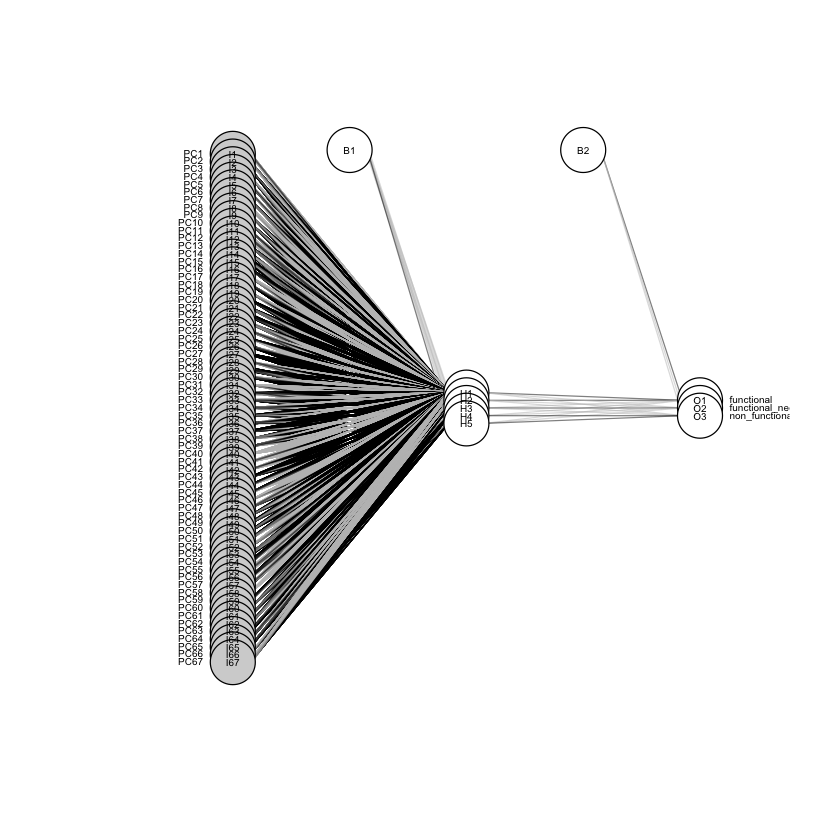

In [87]:
library(devtools)
source_url('https://gist.githubusercontent.com/Peque/41a9e20d6687f2f3108d/raw/85e14f3a292e126f1454864427e3a189c2fe33f3/nnet_plot_update.r')
plot.nnet(model, alpha.val = 0.5, circle.col = list('lightgray', 'white'), bord.col = 'black', cex=0.5)

The following cell presents the 5-fold cross validation with the original dataset

In [ ]:
#nnet

#cross validation of nnet non-pca, ~8 min

CV_folds <- 5

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=1,ncol=CV_folds)
threshold <- 0.5


for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_onehot[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_onehot[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)

    # Model fit (using lm function)
    model<- nnet(status_group~.,data=DS, size=5, maxit=1000, MaxNWts=2000,trace=FALSE)#1000 max iterations ?

    # Model predict
    Y_hat_nnet<- predict(model,X_ts)
    Y_hat <- predict_transform(Y_hat_nnet)
    acc_nnet <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_nnet)
} 

Here is the cell taking labels with a one hot encoding. We will use the PCA dataset since we do not see any significant differences between one another.  

In [ ]:
#nnet one hot

#cross validation of nnet non one hot, ~2,5 min

CV_folds <- 5

size_CV <-floor(N/CV_folds)


for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)

    # Model fit (using lm function)
    model<- nnet(x=X_tr,y=class.ind(as.factor(Y_tr)), size=5, maxit=1000, MaxNWts=2000,trace=FALSE)#1000 max iterations ?

    # Model predict
    Y_hat_nnet<- predict(model,X_ts)
    Y_hat <- predict_transform(Y_hat_nnet)
    acc_nnet <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_nnet)
} 



## Model 3 - Random Forest

The next model we'll evaluate is Breiman and Cutler's Random Forests for Classification and Regression, under the randomForest library. Random forest combines multiple decision trees which were trained individually on a different subset of samples and with different subset of randomly selected features. This random selection decorrelates the predictions of different trees. 


Firstly, we will estimate the number of trees yielding the best overall accuracy. We have to keep in mind that computational time is also a priority, so we'll decide the number of trees based on those two critierion. The next cell plots the accuracy per number of trees.

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30


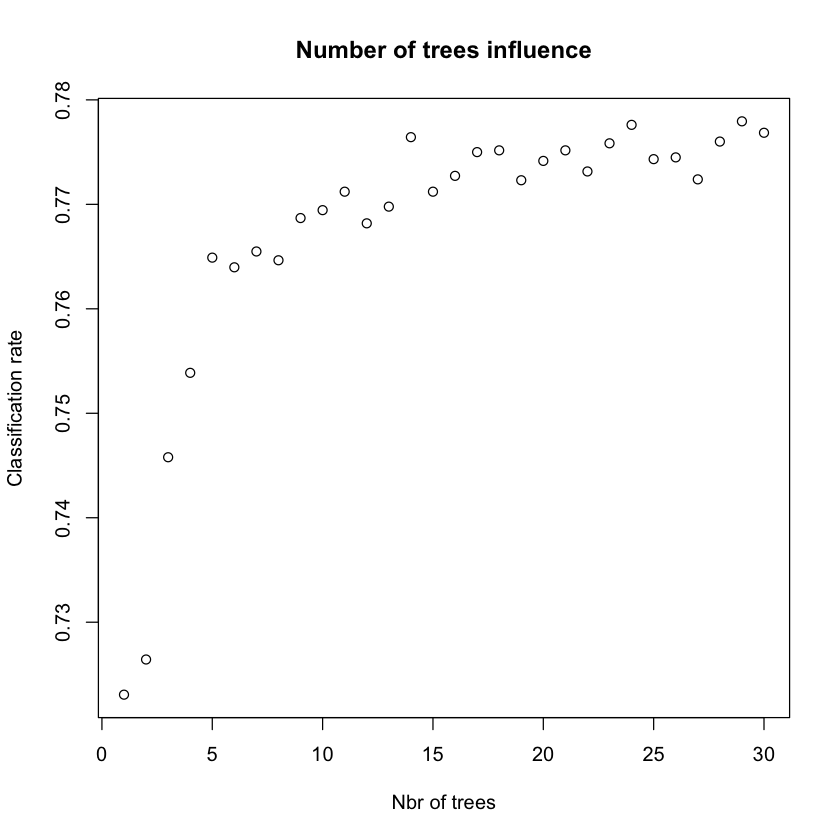

In [97]:
n_trees <- 30

accuracy_vec <- array(0,n_trees)

idx_ts<-((3*size_CV+1):(4*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
X_ts<-X_final[idx_ts,]  
Y_ts<-Y[idx_ts,]


idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
X_tr<-X_final[idx_tr,]
Y_tr<-Y[idx_tr,]         
    # Create a dataset including only the first nb_components principal components
DS<-cbind(X_tr,status_group=Y_tr)
DS$status_group<-factor(DS$status_group)

for (i in 1:n_trees){
    
    nb_trees <- randomForest(status_group~.,data=DS,
                          ntree=i)
    
    Y_hat_rf<- predict(nb_trees,X_ts)
    acc_forest <- confusionMatrix(as.factor(Y_hat_rf),as.factor(Y_ts))$overall['Accuracy']
    accuracy_vec[i] = acc_forest
    }

plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")

Looking at the global shape of the curve, it seems that a good number of trees could be around 15. That way we are close enough to the best accuray while gaining potentially a lot in computational time. 

The next cell applies the 5-fold cross validation on our randomForest, as input our PCA dataset. Note that the randomForest funciton returns labels, and not a "one-hot" probability encoding like the two preceding models, o the function predic_transform is not necessary in that case.

In [98]:
#cross validation of random forest pca input, ~11 min

CV_folds <- 5

size_CV <-floor(N/CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
                     
    #randomForest
    forest<- randomForest(status_group~.,data=DS, ntrees=15)

    # Model predict
    Y_hat_rf<- predict(forest,X_ts)
    acc_forest <- confusionMatrix(as.factor(Y_hat_rf),as.factor(Y_ts))$overall['Accuracy']
    print(acc_forest)
} 

 Accuracy 
0.7823232 
 Accuracy 
0.7799663 
 Accuracy 
0.7830808 
 Accuracy 
0.7806397 
 Accuracy 
0.7822391 


In [ ]:
#cross validation of random forest, ATTENTION BEFORE RUNNING ~24 min

CV_folds <- 5

size_CV <-floor(N/CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_onehot[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_onehot[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
                     
    #randomForest
    forest<- randomForest(status_group~.,data=DS, ntrees=15)

    # Model predict
    Y_hat_rf<- predict(forest,X_ts)
    acc_forest <- confusionMatrix(as.factor(Y_hat_rf),as.factor(Y_ts))$overall['Accuracy']
    print(acc_forest)
} 

Comparing the 2 training procedures, we can see a 1.5% improvement in accuracy when giving the original dataset rather than the PCA reduced one. But this improvement comes with a computational cost, and a rather big one. The training time taken is more than twice the time taken for the model taking PCA as input. So it seems that for random forest, taking the PCA reduced dataset is prefereable overall.

# Alternative models

## XGBoost



As an alternative model, we decided to use a XGBoost model as it is a very popular model in Machine
Learning. XGBoost stands for Extreme Gradient Boosting and is a tree based ensemble machine learning algorithm. Its main advantages are that the execution speed is better than other boosting algorithms and its performance are great.
It requires to encode the classes in our label set starting from 0, which is what we do below.

In [24]:
# XGBoost requires the classes to be in integer format, starting with 0.
set_labels$status_group[set_labels$status_group == 'functional']<-0
set_labels$status_group[set_labels$status_group == 'functional needs repair']<-1
set_labels$status_group[set_labels$status_group == 'non functional']<-2
set_labels$status_group<-factor(set_labels$status_group)

num_class = length(levels(set_labels$status_group))
num_class
states = set_labels$status_group

label = as.integer(states)-1

[1] 3

We split the dataset in a training (75%) and testing (25%) set. We apply it on the datasets where we used PCA and the other without PCA to see the impact of the preprocessing phase.

In [25]:
# data set is split for training (75%) and testing (25%)
n = nrow(X_final)

# training data set is used to fit the model
train.index = sample(n,floor(0.75*n))
train.data = as.matrix(X_final[train.index,])
train.data
train.label = label[train.index]
train.label
#  testing data set is held out for validation
test.data = as.matrix(X_final[-train.index,])
test.label = label[-train.index]
test.label

PC1        PC2         PC3           PC4         PC5         PC6        
19823  3.5541322  1.5816874   2.688565e+00 -0.18842553  0.32189885  0.24404785
37152 -0.8572269 -3.8222453   2.570319e+00  1.14692843  0.66752084  5.99096683
40083  3.0421434  1.3896224   2.215066e+00  0.93302465  0.29490433  0.39170003
4419  -3.7257267  2.8185123  -5.462619e-05 -1.55286826  0.53258472  0.16175615
14728  2.7208345  1.3532260   1.728633e+00  1.80839329 -2.63515575 -0.70584932
36620  0.2768537 -4.4264424  -4.483300e+00 -0.53947433 -3.30703728  4.17651499
8181  -2.9381858  0.8742772   6.243864e-01 -1.76783056  1.07749498  0.34447354
31075 -2.9221468 -0.1979784   1.281213e+00 -1.58276848  0.73610307  1.94755789
42199  3.3901057  0.7538325   8.198629e-01 -0.09152267 -0.09891165 -0.86607336
41237  3.2040479  1.1727122   2.356231e+00  0.90094934 -1.93755043 -0.31183119
40376  4.3273907 -0.4210498  -1.048918e+00 -0.22066897 -7.15701736 -2.33624533
34296  1.9284518 -7.2985062  -5.043559e+00 -3.64914314  0.27296424 -5.49809362
48742  2.8451372  1.5051773   2.390621e+00  1.17754009  0.31226026  0.71875923
38941 -1.4609126  1.1217824   2.007214e+00 -2.59200617  2.00730688  0.99052865
29705 -1.5119021 -5.5480548   3.067889e+00 -0.17353943  0.94283711  5.11997218
30369 -0.4315393 -4.5938064   1.589968e+00 -0.95918112 -0.57427883  0.93146009
46311  3.2334380  0.7762669  -6.048935e-01 -0.43497646  3.88231628  0.09028971
3687  -3.4183234  2.9472139   7.085141e-01 -2.20975737  1.69572962 -0.07890856
47273  3.5639266  0.1734518   1.747633e-01 -0.48447926  4.36870368 -0.66409749
37609 -2.5969023  0.8257486  -3.514805e+00 -1.55745975 -0.19829952  1.51499110
3381  -2.3660637  1.5632831  -7.747564e-01  4.30895759  0.95909131 -1.32178951
31606 -6.4681950  2.1114226  -2.030932e+00 -1.89910308 -2.31568671 -1.36254749
57643 -2.3004467  0.8888223   6.870033e-02  4.22151699  0.24450636 -0.98421204
55190  3.3279650  1.6257360   2.497934e+00 -0.03115790  0.18126776  0.07750698
22784  1.4422497 -6.8572120  -3.122411e+00 -2.40033377  0.99022375  0.27609036
16368  4.1983079  0.6712277   4.435079e-02 -1.02624386  3.93991173 -0.47030231
8945   2.6714779  1.3537062   1.689021e+00  1.77411926 -2.64024051 -0.69066902
23100  3.8447833  0.4445367  -2.707908e+00 -0.10840601  2.15008702 -0.81172614
56906  4.2654786  0.3980974   9.041177e-01 -0.45443319 -4.91955734 -1.52630495
35016  3.4154085  1.2725586   2.062876e+00  0.56000199 -2.74590393 -0.23954831
...   ...        ...         ...           ...         ...         ...        
35948 -3.9302178  2.64400376 -0.34620880   -1.59391967  0.3877918   0.1206885 
35145 -0.7977361  2.00475133  0.68270133    4.25861768 -1.1279808   0.2384148 
26021 -3.4493447  3.01733527 -0.26952693   -2.43072083  0.4632755  -0.4916087 
15034  4.2431673  0.39130268  0.90017280   -0.45630186 -4.9093144  -1.5328418 
34622 -0.6036240 -0.03746523 -1.94153381    3.83464100  3.0758358  -0.5278657 
50137 -4.4961282  0.98528467  1.31248662   -1.38239055  0.8216427  -1.6810554 
17700  4.0482847  0.39052944 -2.61355269   -1.30196205  4.0052210  -1.1671930 
41954  3.3304913  1.50932755  2.71871575    0.47967502  0.4946105   0.4808090 
37686  4.9216758 -0.53337794 -1.73735120   -1.22525558 -1.2373475  -2.2682360 
54603  4.2954723  0.87382969 -2.97607674   -0.59853356  1.6683120  -1.1624028 
1055  -6.4068032  2.10045582 -1.97634546   -2.21794981 -2.2776697  -1.4095774 
22588  2.9048612  1.10627153  2.00064735    1.18663246 -2.0105525   0.6438467 
19655 -4.0874357  2.92050696  0.03304676   -0.90548547  0.3037046   0.4673382 
10303 -0.3072816  1.34980408 -0.39487137    4.20505841 -0.6225146  -1.1344370 
11848 -2.9973968 -9.19480745 -1.32226305   -0.93173283 -3.1357168  -4.1658820 
34045 -4.5621041  3.51732693 -2.51757013   -2.28444983 -1.4508786  -0.6114565 
26358  4.0049213  0.84782559 -0.04655770   -0.87445655  4.2584419  -0.6024568 
13801 -2.7463527  0.33323374 -0.26467295    4.12158427  1.5676500  -2.2223988 
18524  1.9043383 -0.20763499 -0.28179661    2.72079858  

[1] 0 2 2 0 2 0 2 2 0 0 2 2 2 0 2 0 0 0 1 0 2 1 2 0 0 0 2 2 0 0 2 1 2 0 0 0
   [37] 0 2 2 0 0 2 2 0 0 0 0 1 2 0 0 2 2 2 1 2 2 0 0 2 2 0 0 0 0 1 2 0 0 0 2 0
   [73] 2 2 0 1 0 2 1 0 2 0 1 0 2 0 2 1 0 0 2 0 0 0 0 0 0 2 1 0 2 2 2 1 2 2 2 0
  [109] 0 0 0 0 2 1 0 2 0 2 2 0 0 0 1 0 2 0 0 0 0 0 2 2 0 2 0 0 2 0 0 0 2 0 2 2
  [145] 0 0 0 2 0 0 0 0 2 0 2 0 0 2 2 0 0 2 2 0 0 0 0 2 0 2 0 2 2 2 0 0 0 2 0 2
  [181] 2 2 2 2 2 2 1 0 0 0 2 0 1 2 0 0 2 2 0 2 0 2 0 0 2 0 0 0 0 0 2 0 2 0 0 2
  [217] 0 2 0 2 0 2 0 1 0 2 0 2 2 0 1 2 2 0 1 0 0 0 2 2 1 0 2 2 2 0 0 0 0 0 0 2
  [253] 2 2 0 0 0 2 2 1 0 2 2 1 2 0 0 2 0 2 2 0 2 1 0 1 2 0 2 2 1 1 2 0 2 0 1 0
  [289] 2 2 1 0 0 2 0 0 0 0 2 2 2 0 0 2 2 0 2 2 0 2 2 2 0 1 0 0 0 1 0 2 0 2 1 1
  [325] 0 2 2 1 0 0 0 0 0 0 0 0 0 2 0 2 0 2 2 2 2 2 0 2 0 0 0 0 0 0 2 0 2 0 0 0
  [361] 0 1 0 2 2 0 0 0 2 2 0 0 2 0 1 0 2 2 2 0 0 0 0 0 0 0 0 2 0 0 0 1 2 0 1 0
  [397] 0 0 0 0 2 0 0 2 2 2 0 2 0 0 2 0 0 0 1 2 0 2 0 2 2 0 0 0 0 0 0 0 0 0 1 0
  [433] 0 1 2 0 2 1 2 2 0 2 0 0 0 2 0 2 2 0 0 2 2 2 0 2 0 0 0 0 0 2 2 0 0 1 2 0
  [469] 1 2 2 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 1 1 0 0 0 0 0 0 0 2 0 0 2
  [505] 0 0 0 0 1 1 0 0 0 0 0 0 0 0 2 0 1 2 2 0 2 2 2 2 2 2 0 0 0 0 0 2 0 0 2 0
  [541] 0 0 2 0 0 2 0 1 0 2 0 1 1 0 0 2 0 0 0 0 0 0 2 2 0 0 2 2 0 0 0 1 0 2 2 1
  [577] 2 2 0 1 2 2 0 2 2 0 1 0 0 0 2 0 0 2 0 0 0 0 2 1 2 0 0 2 2 0 2 2 0 0 2 0
  [613] 2 2 2 0 2 0 0 2 0 0 0 2 0 2 0 0 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 1 0 0 1
  [649] 0 0 2 2 2 2 2 0 2 0 0 0 2 1 0 2 0 2 1 2 0 0 0 0 2 2 0 0 0 0 2 0 2 2 0 0
  [685] 2 0 1 0 0 2 2 0 0 0 2 0 0 2 2 0 0 0 0 0 2 2 2 0 2 0 2 2 2 0 0 0 0 2 0 0
  [721] 0 0 0 1 0 0 0 2 2 2 0 2 0 2 0 0 2 0 1 2 2 0 1 0 0 2 2 0 2 2 2 0 0 0 0 2
  [757] 1 0 0 0 1 1 1 2 0 2 2 2 0 2 2 2 0 2 2 0 0 2 2 0 0 1 0 0 0 2 2 2 0 0 2 2
  [793] 0 0 2 2 2 0 0 0 0 2 1 2 0 0 2 1 0 0 2 2 0 2 2 1 2 2 0 2 0 0 0 0 2 2 2 2
  [829] 0 0 0 0 1 2 2 0 0 2 0 0 0 0 0 1 0 0 0 2 2 0 1 0 0 0 0 2 2 0 2 0 2 0 0 0
  [865] 0 0 2 0 0 2 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 2 0 1 0 0 0 2 0 0 0 0 2 2 0 0
  [901] 0 2 0 0 0 2 0 0 0 0 2 2 0 2 0 0 0 0 1 2 0 0 0 2 2 2 2 2 0 0 0 0 2 0 2 1
  [937] 0 0 0 2 0 0 2 0 2 2 2 0 0 2 0 0 0 2 0 2 0 0 0 2 0 2 0 1 0 2 2 0 0 0 0 2
  [973] 0 2 2 2 2 0 0 2 1 2 0 2 0 2 0 0 1 0 0 2 0 0 0 2 2 2 2 0 2 2 0 2 0 2 2 0
 [1009] 2 0 0 0 0 1 0 2 0 1 0 0 0 2 1 1 0 2 0 0 2 2 1 0 2 0 2 2 0 0 2 0 2 0 0 0
 [1045] 2 2 2 1 2 0 1 0 0 0 0 2 1 2 2 0 2 0 0 0 2 0 2 2 2 2 2 0 2 2 0 0 0 0 0 0
 [1081] 2 0 0 2 0 1 2 0 2 0 2 2 0 0 0 0 2 2 2 2 2 0 2 0 0 0 0 2 0 0 2 0 0 2 0 2
 [1117] 2 1 2 2 0 2 0 2 0 2 2 0 0 0 0 2 0 2 0 0 0 2 2 1 2 2 2 2 0 0 0 0 0 2 2 2
 [1153] 0 2 0 2 2 0 0 0 2 1 2 0 0 2 2 0 0 0 2 1 0 2 2 2 0 1 0 0 0 2 0 0 2 2 0 0
 [1189] 2 0 0 0 0 0 0 1 2 0 0 0 0 0 2 0 0 0 2 0 2 0 0 2 2 0 2 0 1 2 1 2 0 1 2 0
 [1225] 0 2 0 2 2 0 0 2 2 0 1 2 0 0 0 0 0 2 1 0 0 1 2 0 0 2 0 2 0 0 0 0 0 2 1 0
 [1261] 2 0 2 2 0 2 2 2 0 0 0 0 2 0 2 1 0 2 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 2
 [1297] 2 1 0 1 0 2 2 2 2 1 0 2 0 0 1 0 2 2 0 2 2 0 2 2 0 0 0 0 0 0 0 0 2 0 2 0
 [1333] 0 1 0 2 2 2 0 1 1 0 1 2 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 2 0 0 0 0 0 2 0 2
 [1369] 0 2 2 0 2 2 0 2 2 0 0 0 0 2 0 0 0 2 0 2 2 1 2 2 2 2 2 0 2 1 0 0 0 2 2 2
 [1405] 2 0 2 2 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 2 0 0 0 0 0 2 0 0 0 2 2 2 0
 [1441] 2 2 1 1 2 0 2 0 0 0 0 0 0 2 0 1 0 2 0 0 0 0 2 0 0 2 0 2 0 0 1 2 2 0 2 2
 [1477] 0 2 2 2 2 2 2 0 0 0 0 2 0 0 2 2 0 0 0 2 2 2 2 0 0 0 1 1 0 0 0 2 0 2 2 0
 [1513] 2 0 0 0 2 2 0 0 0 1 2 0 0 0 0 2 2 1 2 0 0 2 0 0 2 0 2 2 0 2 2 1 2 2 0 2
 [1549] 0 2 2 1 2 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0 2 2 0 0 0 2 0 0 0 1 0 0 2 0 2 1
 [1585] 0 0 2 0 0 2 0 0 2 0 0 2 0 0 1 0 2 2 2 2 1 2 0 2 0 2 1 2 2 0 0 0 2 0 0 2
 [1621] 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 2 0 0 2 2 2 2 0 2 0 2 2 1 1 1 1 2 2 1 0 2
 [1657] 2 2 0 0 2 1 0 2 0 2 0 0 0 0 2 0 2 2 0 0 2 0 0 2 1 2 0 0 0 0 2 2 2 2 2 0
 [1693] 2 2 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2 0 0 0
 [1729] 2 2 0 0 0 1 2 0 2 0 0 1 2 0 2 0 2 0 0 0 1 0 2 0 2 0 0 0 0 0 2 0 2 2 0 2
 [1765] 2 0 2 0 0 2 0 0 2 0 2 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 2 2 0 0 2 0 0 2 0 2
 [18

[1] 2 2 0 2 2 0 0 0 0 2 2 2 2 0 2 2 2 2 0 0 2 2 0 0 0 0 2 0 2 2 0 2 2 0 2 2
   [37] 0 0 0 0 2 2 0 2 0 0 2 0 0 1 0 0 0 2 1 0 2 2 0 2 1 0 2 0 0 0 0 0 2 2 2 2
   [73] 2 2 1 1 0 2 2 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 2 0 2 2 2 0 0 2 1 2 0 2 2 0
  [109] 1 0 2 0 2 0 0 0 0 0 0 2 0 0 2 0 1 2 2 0 0 2 2 2 2 2 2 0 0 0 2 2 0 0 2 1
  [145] 0 0 1 0 2 2 0 2 2 2 0 0 0 2 2 0 0 0 2 1 2 0 0 0 0 0 0 2 2 0 2 2 2 2 0 2
  [181] 2 0 0 0 0 0 0 1 2 2 2 0 0 0 0 2 2 2 2 2 2 0 0 0 2 0 0 0 2 2 2 2 2 0 0 2
  [217] 2 0 2 0 0 2 2 2 0 0 0 0 0 2 0 0 2 2 0 2 2 0 0 2 2 1 2 0 0 0 2 0 2 2 0 2
  [253] 2 0 0 0 2 0 2 0 2 0 2 0 2 0 0 0 2 0 2 0 1 0 0 0 0 0 0 2 0 0 0 2 2 2 0 0
  [289] 0 0 2 2 2 2 0 2 2 2 1 0 0 0 2 1 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 1 2 0 0 0
  [325] 2 0 0 1 0 2 0 0 2 2 0 2 0 2 2 0 0 2 2 0 0 2 0 0 0 0 2 0 2 0 0 0 0 2 0 0
  [361] 0 2 1 2 2 0 2 2 2 2 2 1 0 0 2 2 0 1 1 0 0 1 0 0 0 2 0 2 0 1 0 1 0 0 0 0
  [397] 0 0 2 2 0 0 0 0 0 2 0 2 2 0 2 2 0 2 0 2 0 0 1 0 0 0 2 2 2 2 2 0 2 0 0 1
  [433] 2 0 2 0 2 2 0 2 2 2 0 2 0 2 0 1 0 0 2 2 0 1 0 0 0 2 2 1 0 0 0 0 1 0 0 2
  [469] 1 1 2 2 0 0 0 0 0 0 0 2 1 2 0 2 2 2 2 0 2 2 2 2 2 0 2 2 0 2 1 0 0 0 2 0
  [505] 2 2 2 2 0 2 2 1 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 1 0 0 0 0 0 2 2 0 0 1 0 2
  [541] 0 0 0 0 0 0 0 0 1 2 0 0 0 2 0 2 0 2 0 0 0 0 0 2 0 2 0 0 2 0 2 2 0 2 0 0
  [577] 2 0 2 0 2 0 2 0 2 2 0 2 2 0 2 2 2 2 2 0 0 2 1 0 2 0 0 1 0 0 2 2 2 0 1 1
  [613] 0 2 2 0 2 0 0 0 0 2 2 2 0 2 0 2 0 0 2 2 0 0 2 0 0 0 0 0 2 2 0 1 0 0 2 2
  [649] 0 0 0 2 2 0 2 0 1 2 2 0 0 2 2 0 1 0 2 0 2 0 0 0 1 0 0 0 0 2 0 2 0 0 2 0
  [685] 0 0 0 0 0 1 0 0 2 2 0 0 0 0 0 2 0 0 2 0 2 0 0 2 2 1 2 0 0 2 0 0 0 2 2 0
  [721] 0 0 0 2 2 0 2 0 0 0 2 2 2 0 0 2 2 2 2 2 0 0 0 1 2 1 0 1 0 0 2 2 0 0 0 2
  [757] 0 1 0 1 0 2 0 0 1 0 0 2 2 0 0 0 0 2 0 2 2 2 2 0 0 2 2 0 2 1 0 0 2 0 0 2
  [793] 0 2 0 1 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 2 0 0 2 0 0 0 2 2 2 0 2 2 2 2 0
  [829] 0 0 0 2 0 1 2 2 0 0 2 0 0 0 0 0 1 0 2 2 2 2 0 2 2 0 0 0 2 0 1 2 2 1 0 2
  [865] 0 0 0 0 0 2 2 2 2 0 2 2 1 2 0 0 2 0 0 0 2 0 2 0 2 0 0 0 2 0 0 2 2 0 0 1
  [901] 2 2 0 1 0 0 0 2 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 0 0 2 2 0 2 2 0 0 0 0 0 0
  [937] 0 1 0 2 0 2 0 2 2 2 2 2 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 2 2 0 0 0 0 2 2 0
  [973] 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 2 2 1 0 2 0 1 2 2 0 1 0 0
 [1009] 2 2 0 2 0 0 1 0 2 0 1 2 0 0 1 2 2 0 2 2 0 1 2 0 0 2 2 0 0 2 2 2 2 2 1 0
 [1045] 2 0 2 0 0 0 2 2 0 2 0 2 2 0 0 2 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 2 0 2
 [1081] 0 2 0 2 2 0 2 0 2 2 2 0 0 0 0 0 2 2 2 2 0 0 0 1 2 2 0 2 2 2 2 0 0 0 0 0
 [1117] 2 1 2 0 2 0 0 0 2 0 0 2 1 0 2 2 0 0 0 1 0 2 2 0 2 0 0 0 0 2 2 0 0 0 0 0
 [1153] 0 0 0 2 0 2 0 0 0 0 2 0 0 0 1 0 0 0 2 0 2 2 0 2 0 0 0 0 0 0 2 2 0 0 0 0
 [1189] 0 2 0 2 0 2 0 1 2 2 0 0 2 0 1 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0
 [1225] 2 0 0 0 2 0 2 2 1 0 0 0 0 0 1 0 0 2 0 2 0 2 0 0 2 2 2 0 0 1 1 2 2 0 0 0
 [1261] 0 0 2 2 2 1 0 2 2 0 1 2 0 0 0 2 0 0 0 0 0 0 2 2 0 2 0 1 2 0 2 1 0 2 1 0
 [1297] 2 0 2 2 0 2 0 2 0 2 2 2 2 1 2 2 0 1 0 0 2 0 0 0 2 0 0 0 0 0 0 0 1 0 1 0
 [1333] 0 2 2 0 1 0 2 2 0 1 2 2 2 0 2 2 0 0 2 0 0 2 0 0 2 0 0 0 2 2 0 2 2 2 1 0
 [1369] 2 2 0 2 0 0 0 1 0 2 0 2 2 1 2 2 2 0 0 0 2 0 0 1 0 2 0 0 2 0 0 0 0 2 0 0
 [1405] 0 2 0 0 0 2 2 2 2 0 2 2 0 0 0 0 0 0 1 2 0 2 0 0 2 0 0 2 0 0 1 2 2 1 0 0
 [1441] 0 2 0 0 2 0 2 0 2 2 0 2 2 0 0 1 1 0 0 2 2 0 0 2 0 0 0 2 0 2 2 0 1 0 0 2
 [1477] 2 0 0 2 0 0 0 2 2 0 2 2 0 1 2 0 2 0 2 0 2 1 2 0 2 2 0 0 2 2 2 0 2 2 0 0
 [1513] 0 0 2 0 0 0 2 2 2 0 1 1 2 0 2 0 0 0 0 0 0 2 0 0 0 2 0 0 2 1 0 0 0 2 0 0
 [1549] 0 0 2 2 0 1 2 0 0 0 0 0 2 0 2 2 2 0 2 0 0 2 2 0 0 1 2 2 2 2 2 0 2 0 0 2
 [1585] 0 0 1 2 0 0 0 0 0 0 2 2 2 2 0 0 0 0 2 2 1 0 2 2 0 2 0 0 1 0 0 2 1 2 0 2
 [1621] 2 2 2 2 2 1 0 2 2 0 0 2 1 2 2 0 2 2 0 0 0 2 1 0 1 2 0 2 0 2 0 2 0 0 2 2
 [1657] 0 2 1 0 0 0 0 0 2 0 2 2 0 2 0 0 2 0 0 2 2 2 0 2 0 1 2 1 1 2 2 2 0 2 0 2
 [1693] 2 0 0 2 0 2 2 0 0 2 2 2 2 0 2 0 0 2 0 2 2 0 2 0 0 2 0 0 0 2 2 0 1 0 2 2
 [1729] 2 0 0 0 0 0 0 0 2 1 0 0 0 2 0 0 2 0 0 0 2 2 0 0 0 2 2 2 0 2 2 0 0 2 0 0
 [1765] 2 0 0 2 0 2 2 0 2 2 0 2 0 2 0 0 0 2 0 0 0 2 0 0 1 2 2 2 2 0 0 0 0 2 0 2
 [18

In [26]:
# data set is split for training (75%) and testing (25%)
n = nrow(X_final)

# training data set is used to fit the model
train_nopca.index = sample(n,floor(0.75*n))
train_nopca.data = as.matrix(X_onehot[train_nopca.index,])
train_nopca.data
train_nopca.label = label[train_nopca.index]
train_nopca.label
#  testing data set is held out for validation
test_nopca.data = as.matrix(X_onehot[-train_nopca.index,])
test_nopca.label = label[-train_nopca.index]
test_nopca.label

amount_tsh gps_height longitude latitude   basin_Internal
36570    0       1682       31.27300   -7.779673 0             
8908   100         49       39.03090   -6.579018 0             
27437    0        277       38.90148  -10.864399 0             
8165     0          0       31.29607   -2.586677 0             
47890    0          0       32.59843   -2.513756 0             
53438    0          0       33.94527   -9.391376 0             
21746    0       1174       33.10010   -2.084647 0             
52674    0          0       35.00594   -5.172704 0             
41454    0       1201       34.00468   -2.039307 0             
40815 1000          0       37.18277   -6.045599 0             
19948    0        471       37.94791   -9.809744 0             
29715    0        297       38.55968   -5.141425 0             
51850    0       1150       32.93032   -2.069332 0             
881     50         36       38.84171   -6.588827 0             
34333    0          0       33.00283   -9.365566 0             
9844     5       1561       37.25874   -3.196374 0             
4060     0          7       40.18948  -10.414099 0             
52287  300          0       37.29510   -6.401233 0             
4589     5        995       37.26938   -3.309957 0             
16299    0          0       33.32044   -4.107522 1             
21683    0       1576       36.68443   -3.324040 0             
10660    0          0       33.74125   -3.163528 0             
24546    0          0       32.82295   -2.527829 0             
29195    0          0       31.44339   -1.198211 0             
54023    0          0       33.65428   -9.307951 0             
43435    0          0       32.08618   -4.217636 0             
22105   50        975       29.67253   -4.778313 0             
45756  500       1612       34.67209   -9.019850 0             
25708    0        463       34.64858  -11.109534 0             
14373    0       1193       38.46742   -4.932920 0             
...   ...        ...        ...       ...        ...           
1542     5       1062       37.19991   -3.296205 0             
40371    0          0       33.17098   -9.229985 0             
31553    0          0       33.76529   -9.513359 0             
54315    0       1278       37.41506   -3.313126 0             
49042    0          0       32.84393   -2.908804 0             
37083    0          0       31.16916   -1.541177 0             
38426    0          0       33.71441   -9.209284 0             
40045    0          0       31.12874   -1.405182 0             
7664     0          0       33.23130   -2.550557 0             
4407     0       1228       35.08011   -5.322089 1             
51554    0       1329       37.60652   -3.289749 0             
2919     0        313       36.36253   -8.797740 0             
57671    0          0       32.57063   -3.642708 0             
49221    0         42       39.17380   -7.211194 0             
28846 1000       1423       34.51967   -4.657079 1             
37448   20        227       38.33039   -6.456959 0             
44706  500        996       29.74249   -4.736452 0             
16667    0        267       39.02028  -10.871395 0             
13569 5000        767       30.40623   -6.740832 0             
44040    0          0       32.79348   -5.092346 0             
22217    0          0       33.63529   -8.854277 0             
30091    0       1423       34.37832   -2.933724 0             
58257  250       1418       30.10605   -4.369916 0             
506      0       1304       30.83763   -3.642015 0             
30806    0          0       33.05605   -3.830951 1             
27506    0          0       33.36752   -3.164679 0             
35195    0          0       35.00594   -5.172704 0             
39107    0       1335       30.66074   -3.546127 0             
38965    0       1411       30.82232   -3.053207 0             
50419  500        902       35.98226  -10.699981 0             
      basin_Lake.Nyasa basin_Lake.Rukw

[1] 2 0 2 2 0 0 1 2 2 2 2 0 1 0 0 0 2 2 2 0 0 0 2 2 0 2 1 0 2 0 0 2 0 0 1 2
   [37] 0 2 2 2 0 0 1 0 2 0 0 0 2 0 0 0 0 2 0 0 2 0 1 0 0 0 2 0 0 2 1 0 0 0 2 0
   [73] 0 0 0 0 0 0 2 2 2 2 0 0 0 2 2 2 2 0 0 0 2 0 2 2 2 2 0 2 0 0 0 0 2 2 0 2
  [109] 2 1 0 2 0 0 2 0 0 0 0 2 0 2 0 2 1 0 2 0 0 0 0 0 0 2 2 0 1 0 0 0 0 2 0 2
  [145] 0 0 2 0 0 0 0 2 0 2 0 2 2 2 0 0 2 2 2 0 0 2 2 0 2 2 2 0 1 0 0 0 0 2 2 1
  [181] 2 0 0 0 2 1 0 0 0 2 0 2 2 2 0 0 2 0 1 2 2 2 0 2 2 0 2 2 2 0 2 0 1 0 0 2
  [217] 0 0 0 0 0 0 1 0 0 2 0 2 0 2 0 2 0 0 0 2 1 0 0 0 0 2 0 2 2 0 2 2 0 0 0 0
  [253] 0 2 2 2 0 2 0 0 0 2 2 2 0 0 2 0 0 0 2 2 0 0 2 2 2 2 0 2 0 0 0 0 0 2 2 1
  [289] 2 0 2 2 0 0 1 0 1 2 2 1 0 2 0 2 1 0 2 0 2 1 0 0 0 0 0 0 2 0 2 2 0 2 0 2
  [325] 0 2 0 2 2 0 0 0 0 0 0 0 2 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2
  [361] 2 0 1 0 2 0 2 2 2 0 0 0 0 0 0 0 2 2 2 2 0 0 2 0 0 2 0 0 2 0 0 0 0 2 0 0
  [397] 0 0 1 0 0 2 0 2 2 0 0 2 2 0 2 2 0 0 0 2 0 0 0 0 0 0 2 0 2 0 2 0 2 0 0 2
  [433] 0 2 0 2 0 0 0 0 2 2 0 2 0 2 2 2 2 0 1 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2
  [469] 0 2 0 0 0 2 0 2 0 0 0 0 1 0 2 2 0 0 2 2 2 2 2 0 0 0 1 0 0 2 2 0 0 2 0 0
  [505] 0 2 1 0 2 0 0 2 2 1 0 0 0 0 2 2 2 0 0 0 0 0 2 2 1 2 2 2 0 2 2 0 2 0 2 0
  [541] 2 0 0 0 0 2 0 0 0 0 1 0 0 2 0 2 0 0 2 0 2 0 0 0 0 0 0 2 0 2 2 0 2 2 2 0
  [577] 2 0 0 0 2 0 1 2 0 2 1 0 0 0 2 2 0 2 2 2 2 0 2 2 2 0 2 2 0 0 0 2 2 0 2 0
  [613] 2 2 0 0 2 2 2 0 2 0 0 0 0 2 0 2 0 0 2 0 2 0 0 2 0 0 2 2 1 2 1 0 0 0 2 2
  [649] 0 2 0 0 2 0 2 2 1 2 2 0 2 2 2 2 2 0 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 0 2 2
  [685] 2 0 2 2 2 0 2 2 2 2 2 2 2 0 0 0 1 0 0 0 0 0 2 0 0 2 0 1 2 0 2 1 2 2 0 2
  [721] 0 0 2 0 0 2 2 0 2 0 2 2 0 2 0 0 2 1 2 0 2 0 0 0 0 0 0 2 2 2 2 0 0 2 0 2
  [757] 0 2 0 0 2 0 0 1 2 0 0 0 2 2 2 1 2 0 2 0 0 0 0 0 2 0 0 2 2 2 2 2 0 0 0 2
  [793] 2 0 0 0 0 0 0 0 0 1 0 0 2 0 0 2 0 0 0 0 2 2 2 2 1 0 0 0 2 2 2 0 1 2 2 0
  [829] 2 2 0 2 0 1 0 0 0 0 0 0 0 2 0 2 1 0 2 1 2 0 0 0 2 2 0 0 0 0 0 2 2 2 0 0
  [865] 2 0 0 2 0 0 1 0 2 2 0 0 2 2 0 0 2 0 0 2 0 0 2 0 2 2 1 0 0 2 0 0 1 2 1 0
  [901] 2 2 0 0 0 0 0 2 2 1 0 0 2 0 0 0 0 2 0 0 0 2 0 2 0 0 0 2 0 0 0 0 0 0 0 0
  [937] 0 2 0 0 2 2 0 1 0 2 1 1 1 0 2 2 0 0 0 0 2 1 0 2 0 2 2 0 2 2 2 0 0 0 2 0
  [973] 2 0 2 0 0 0 2 0 0 2 0 2 0 2 1 1 2 0 2 2 2 0 0 2 0 0 2 2 0 0 2 1 0 2 0 2
 [1009] 0 0 0 0 0 1 0 0 2 0 2 0 0 1 2 2 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 2
 [1045] 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 1 0 2 0 0 0 0 0 2 0 2 0 0 0 2 2 0 0 2
 [1081] 0 2 2 0 0 0 2 0 2 0 0 0 2 2 0 0 2 2 0 0 2 1 0 0 0 2 0 2 0 0 0 0 0 1 2 2
 [1117] 2 0 2 2 2 0 2 0 0 2 2 2 2 2 2 0 0 0 2 2 1 0 2 0 0 1 1 2 1 2 2 0 2 0 0 0
 [1153] 0 0 2 2 0 0 2 0 0 2 2 2 0 0 2 0 0 2 0 0 2 0 2 2 0 0 2 2 1 2 2 2 0 0 2 2
 [1189] 0 0 0 0 2 0 0 2 1 2 2 0 2 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 2 1 0 2
 [1225] 2 0 2 2 0 2 0 2 0 0 1 0 2 0 0 1 0 2 2 2 0 1 2 0 0 0 2 2 2 0 0 1 0 2 0 0
 [1261] 1 0 0 0 2 0 0 2 0 0 2 1 0 0 0 0 2 2 0 0 2 0 2 0 0 0 0 2 2 0 2 2 0 0 0 2
 [1297] 0 0 2 0 0 0 0 1 2 0 0 0 2 0 2 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 2 2 2 2 0 0
 [1333] 2 2 0 0 2 0 0 0 0 2 2 1 0 2 0 0 0 2 2 0 2 0 2 1 0 0 0 0 2 1 0 0 0 0 0 2
 [1369] 0 2 0 2 0 2 2 0 1 2 0 0 0 2 0 2 0 0 2 0 0 0 2 2 1 0 0 2 2 0 2 2 2 2 0 0
 [1405] 0 0 0 0 0 0 2 0 0 0 2 2 0 1 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 2 2
 [1441] 0 1 1 0 1 1 0 0 2 0 1 0 0 1 2 0 0 0 2 2 2 1 0 2 0 0 2 2 0 0 0 0 0 0 1 0
 [1477] 2 2 0 0 0 0 0 0 2 2 0 2 0 1 0 2 0 0 0 2 0 1 2 0 0 2 0 0 0 0 0 2 2 0 0 2
 [1513] 2 1 2 2 0 0 0 2 0 0 0 2 0 0 0 0 0 0 1 0 0 0 2 0 2 0 0 2 0 2 2 1 0 0 2 2
 [1549] 0 2 0 0 0 0 2 0 0 2 2 0 0 2 0 1 0 0 2 2 2 0 0 2 2 2 0 0 0 0 0 2 0 2 0 2
 [1585] 0 0 2 0 2 2 0 0 0 2 0 0 0 2 0 2 0 0 0 2 2 0 2 2 2 2 2 0 0 2 0 0 0 0 0 0
 [1621] 2 0 2 2 0 0 2 0 2 0 1 2 0 0 2 2 2 2 0 2 1 2 0 0 2 2 0 2 0 2 0 1 0 0 0 0
 [1657] 2 2 2 0 2 0 0 2 0 0 0 2 0 1 0 1 0 0 0 2 0 0 2 2 2 0 0 0 0 0 2 0 1 0 2 0
 [1693] 2 2 0 2 2 2 0 2 0 0 2 0 0 0 0 2 2 0 0 0 0 0 1 0 0 0 2 2 0 1 2 2 2 0 2 2
 [1729] 0 0 2 2 0 2 0 2 0 0 0 1 0 0 2 2 0 2 2 0 2 2 2 1 0 0 0 0 2 0 2 0 1 0 0 0
 [1765] 2 0 2 1 0 1 2 0 2 0 2 2 0 2 0 0 2 0 1 1 2 2 0 1 0 0 1 2 2 1 2 0 0 0 2 2
 [18

[1] 0 0 1 1 0 0 1 1 2 2 0 2 2 2 2 0 2 2 1 2 0 2 0 0 0 0 0 0 2 0 0 1 0 2 0 2
   [37] 1 0 0 0 0 0 0 0 0 0 2 2 0 2 1 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 2 2 2 0
   [73] 2 2 0 2 2 0 0 0 2 2 0 0 0 0 0 2 2 0 2 0 0 2 2 2 2 2 0 0 2 0 0 0 0 0 2 0
  [109] 0 0 2 0 2 2 2 2 0 2 0 0 2 2 0 0 0 2 0 0 0 2 0 2 2 1 0 0 2 2 0 0 0 0 1 0
  [145] 2 0 2 2 1 2 0 0 2 2 2 0 0 2 1 2 2 2 0 0 0 2 0 1 0 0 1 0 0 0 0 2 1 2 0 1
  [181] 0 0 1 2 0 0 0 0 2 0 2 0 2 2 2 1 2 0 0 2 1 2 0 2 0 0 2 2 0 0 0 0 0 0 0 0
  [217] 0 0 2 0 0 2 2 0 0 2 2 2 2 0 2 0 2 0 1 2 2 0 1 1 0 2 2 1 2 0 2 0 1 0 0 2
  [253] 2 0 2 2 0 2 0 0 2 0 0 0 2 0 0 2 0 2 0 0 2 2 0 0 2 2 2 0 2 2 0 2 2 2 2 0
  [289] 2 0 0 2 2 2 0 2 0 0 1 0 0 0 0 0 0 2 0 0 2 0 1 0 0 0 0 2 0 0 2 2 1 0 0 2
  [325] 0 2 2 0 2 0 0 1 2 0 0 0 2 0 0 1 0 0 0 0 0 0 2 2 2 0 2 0 2 0 2 2 1 0 2 2
  [361] 2 0 0 2 1 2 0 0 0 2 2 0 1 0 0 2 2 1 2 0 2 2 2 0 0 0 0 2 0 2 2 2 2 1 0 2
  [397] 0 1 2 2 0 0 0 0 0 0 0 0 2 0 0 2 0 2 2 2 0 0 0 2 0 0 0 2 0 2 2 2 2 0 0 0
  [433] 1 0 2 2 0 2 0 0 2 0 2 2 0 0 2 0 1 0 2 0 1 0 0 0 2 2 0 2 2 0 0 0 0 1 0 0
  [469] 0 2 0 2 0 0 0 0 0 0 0 1 0 0 0 2 2 0 0 0 2 2 2 2 2 0 1 2 1 1 0 2 2 0 0 2
  [505] 0 2 0 2 0 0 0 2 2 0 0 0 2 0 0 0 2 2 2 2 0 0 2 2 0 0 2 0 2 0 0 1 0 2 2 2
  [541] 2 2 0 1 0 0 1 2 0 2 2 2 0 0 0 1 0 2 0 2 0 2 2 0 0 2 0 2 0 2 2 0 2 0 2 0
  [577] 0 2 2 2 2 0 2 2 2 0 2 2 1 0 1 0 2 2 0 0 0 2 2 2 0 0 0 2 0 2 0 2 1 0 0 0
  [613] 0 2 0 1 2 2 0 0 2 0 0 2 0 0 0 0 2 0 0 2 2 2 2 2 0 0 0 2 2 2 0 0 0 0 2 0
  [649] 0 0 0 2 1 0 2 0 0 0 0 0 2 2 2 0 0 2 2 2 1 0 0 2 2 2 0 0 0 0 0 2 0 2 0 0
  [685] 2 0 0 2 2 2 0 0 1 1 0 0 2 0 1 0 0 0 2 0 0 2 2 0 2 1 0 0 2 0 0 2 2 2 2 0
  [721] 2 0 2 2 0 0 0 0 2 0 2 0 0 2 2 1 0 2 0 1 0 0 0 0 0 0 2 0 0 0 0 2 2 2 2 2
  [757] 0 0 0 2 2 0 0 0 2 2 2 2 1 2 0 0 2 2 0 2 0 2 0 0 0 0 0 2 0 2 2 0 0 2 0 0
  [793] 0 0 2 2 2 2 2 1 0 0 1 2 0 0 0 2 0 0 2 0 2 0 0 0 2 2 0 0 0 2 2 2 2 2 0 2
  [829] 0 2 0 2 2 0 2 0 2 2 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 2 2 2 0 2 0 0 0 2 0 0
  [865] 2 0 0 0 0 2 0 2 0 2 0 1 2 0 1 2 0 2 0 0 2 0 0 0 0 0 0 2 1 0 0 0 0 2 2 0
  [901] 2 2 0 0 1 2 2 0 0 1 0 2 2 0 0 0 2 0 0 2 0 2 2 1 0 2 0 0 2 1 2 0 2 2 0 2
  [937] 1 0 0 0 0 0 2 1 0 0 0 2 0 2 2 0 2 0 2 0 0 0 2 0 0 2 0 0 2 0 0 0 0 0 2 0
  [973] 0 0 2 0 1 0 0 0 0 2 0 2 1 2 2 2 0 0 0 0 2 1 0 2 2 0 2 0 2 2 0 2 2 0 0 0
 [1009] 0 0 2 0 0 2 2 0 0 0 0 0 2 2 0 2 0 2 0 0 1 0 2 2 0 2 2 0 0 2 0 0 0 2 2 0
 [1045] 0 0 0 2 0 2 2 2 0 2 0 0 0 2 0 0 0 2 2 0 2 2 0 2 2 2 2 0 0 2 2 2 0 0 0 0
 [1081] 0 2 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 1 0 2 0 1 2 0 1 2 0 2 2 2 0 0 1 0
 [1117] 0 0 0 2 0 0 0 0 0 2 0 2 0 0 0 2 2 2 2 0 2 0 0 2 2 0 2 1 0 0 0 2 2 0 0 0
 [1153] 2 0 0 2 0 2 2 0 0 0 1 2 0 0 0 2 2 0 2 0 0 2 2 0 0 0 0 0 0 2 0 0 0 2 2 2
 [1189] 0 0 2 0 0 2 0 1 2 0 2 0 0 0 0 0 1 2 2 2 1 0 0 0 0 2 2 0 0 2 0 0 0 2 2 0
 [1225] 1 0 0 0 2 0 2 2 2 0 0 0 1 0 1 0 0 1 2 2 0 0 2 2 0 1 0 0 0 2 0 1 0 2 2 2
 [1261] 1 1 0 2 0 2 2 2 0 0 2 0 0 0 0 2 2 2 0 0 2 0 0 0 2 0 2 0 2 1 0 1 2 0 2 0
 [1297] 2 0 0 0 2 0 2 2 0 0 0 0 0 0 2 0 2 0 2 0 2 0 0 0 1 0 1 1 0 2 2 2 0 2 0 0
 [1333] 1 0 2 0 0 2 2 2 0 0 0 2 0 0 0 2 2 0 2 0 1 2 0 2 0 2 0 2 2 2 2 0 0 2 2 0
 [1369] 0 2 0 2 2 0 0 2 0 0 0 0 0 2 0 0 2 0 2 2 2 2 0 2 2 0 1 0 0 0 0 0 0 0 0 0
 [1405] 2 0 2 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 0 2 0 1 0 2 0 2 0 0 2
 [1441] 1 0 1 2 1 0 2 0 2 0 0 0 2 0 0 0 0 0 0 2 2 2 0 2 2 2 0 1 0 2 2 0 1 0 2 2
 [1477] 0 2 2 2 2 2 2 0 1 2 2 0 0 2 2 0 2 0 0 2 2 2 2 0 2 2 0 0 0 0 0 0 0 2 2 0
 [1513] 2 0 2 0 0 0 2 2 0 2 2 2 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 2 2 2 0 0 2 2 2 0
 [1549] 0 1 0 0 0 2 2 0 0 0 0 1 1 0 0 2 0 0 0 2 2 0 2 2 2 0 2 1 0 0 0 0 2 2 0 2
 [1585] 1 2 0 2 1 0 2 0 0 0 0 0 0 2 0 2 0 0 1 2 0 0 1 1 0 2 0 2 2 2 0 2 2 0 1 0
 [1621] 0 0 0 0 1 2 2 2 0 2 2 2 0 2 2 1 0 0 2 2 2 2 2 2 0 0 2 1 2 0 2 2 0 2 0 0
 [1657] 2 2 0 0 2 0 2 2 2 0 0 0 0 2 2 0 0 2 1 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1
 [1693] 0 0 2 2 0 0 2 2 0 0 0 0 2 2 0 2 1 0 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0
 [1729] 0 0 0 2 2 0 2 0 2 2 0 2 0 2 0 0 2 2 2 0 2 1 1 0 0 0 1 0 0 2 2 0 0 2 0 0
 [1765] 2 1 2 0 0 2 0 0 2 2 2 0 0 1 2 1 0 0 0 0 0 0 2 2 2 2 0 0 2 0 0 0 2 0 0 2
 [18

In [27]:
# DMatrix objects that are used for fitting the XGBoost model and predicting new outcomes
xgb.train = xgb.DMatrix(data=train.data,label=train.label)
xgb.test = xgb.DMatrix(data=test.data,label=test.label)

In [38]:
xgb_nopca.train = xgb.DMatrix(data=train_nopca.data,label=train_nopca.label)
xgb_nopca.test = xgb.DMatrix(data=test_nopca.data,label=test_nopca.label)

XGBoost works best when its parameters are hypertuned for optimal performance.
Here, found the parameters to be optimal through simple tests, changing one parameter at a time. The parameter eta is the step size of each boosting step. The max.depth is the maximum depth of the tree. Gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree.
The objective parameter multi:softprob tells the algorithm to calculate probabilities for every possible outcome
(in this case, a probability for each of the three states of water pumps), for every observation.
The parameter eval_metric mlogloss tells the XGBoost algorithm that we want to use a multiclass logloss as our evaluation metric.


In [29]:
# Define the parameters for multinomial classification
num_class = length(levels(states))
num_class
params = list(
  booster="gbtree",
  eta=0.3,
  max_depth=8,
  gamma=0,
  subsample=0.75,
  colsample_bytree=1,
  objective="multi:softprob",
  eval_metric="mlogloss",
  num_class=num_class
)

[1] 3

We use the cross validation to asses the error rate because if we rely on one simple training and validation set, the results can be vastly different depending on the split of the data chosen.

In [35]:
cv.nfold  <- 5 # cv.nfold value here is arbitrary chosen. The number of cv.nfold will typically be 5 or 10


cv_model <- xgb.cv(params = params,
                   data = xgb.train,
                   nrounds = 100,
                   nfold = cv.nfold,
                   verbose = TRUE,
                   nthread=1,
                   early_stopping_rounds=30,
                   prediction = TRUE)



[1]	train-mlogloss:0.914063+0.000713	test-mlogloss:0.927067+0.001775 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 30 rounds.

[2]	train-mlogloss:0.796421+0.001738	test-mlogloss:0.820545+0.002038 
[3]	train-mlogloss:0.714082+0.001646	test-mlogloss:0.748214+0.003906 
[4]	train-mlogloss:0.654988+0.002021	test-mlogloss:0.698777+0.004916 
[5]	train-mlogloss:0.609775+0.002052	test-mlogloss:0.662692+0.005151 
[6]	train-mlogloss:0.573681+0.002573	test-mlogloss:0.635825+0.005484 
[7]	train-mlogloss:0.544018+0.003079	test-mlogloss:0.615248+0.005535 
[8]	train-mlogloss:0.519640+0.003227	test-mlogloss:0.599881+0.006570 
[9]	train-mlogloss:0.498963+0.002207	test-mlogloss:0.587402+0.007325 
[10]	train-mlogloss:0.481705+0.002266	test-mlogloss:0.578077+0.007339 
[11]	train-mlogloss:0.467770+0.002212	test-mlogloss:0.571054+0.007166 
[12]	train-mlogloss:0.456705+0.002392	test-mlogloss:0.565669+0.007299 
[13]	train-mloglo

In [40]:
#No PCA

cv_nopca_model <- xgb.cv(params = params,
                   data = xgb_nopca.train,
                   nrounds = 100,
                   nfold = cv.nfold,
                   verbose = TRUE,
                   nthread=1,
                   early_stopping_rounds=30,
                   prediction = TRUE)

[1]	train-mlogloss:0.917467+0.000860	test-mlogloss:0.922171+0.001443 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 30 rounds.

[2]	train-mlogloss:0.807518+0.000405	test-mlogloss:0.816782+0.001875 
[3]	train-mlogloss:0.733848+0.000689	test-mlogloss:0.747140+0.002478 
[4]	train-mlogloss:0.682582+0.000627	test-mlogloss:0.699109+0.003213 
[5]	train-mlogloss:0.643902+0.000536	test-mlogloss:0.663783+0.004031 
[6]	train-mlogloss:0.614604+0.001244	test-mlogloss:0.638179+0.004376 
[7]	train-mlogloss:0.591324+0.001424	test-mlogloss:0.618997+0.004436 
[8]	train-mlogloss:0.573477+0.001974	test-mlogloss:0.604918+0.004689 
[9]	train-mlogloss:0.557638+0.001949	test-mlogloss:0.592669+0.004874 
[10]	train-mlogloss:0.543946+0.001027	test-mlogloss:0.582445+0.005890 
[11]	train-mlogloss:0.533297+0.000796	test-mlogloss:0.575193+0.006982 
[12]	train-mlogloss:0.523405+0.001233	test-mlogloss:0.568481+0.007456 
[13]	train-mloglo

The pred object contains the predicted value for each observation in our train dataset
To test the prediction, we need to assign a class, which is why we use max.col() to assign the class that has the highest probability. 

In [42]:
# the probability that each observation belongs to each class
OOF_prediction <- data.frame(cv_model$pred) %>%
  mutate(max_prob = max.col(., ties.method = "last"),
         label = train.label + 1)
head(OOF_prediction)

OOF_prediction_nopca <- data.frame(cv_nocpa_model$pred) %>%
  mutate(max_prob = max.col(., ties.method = "last"),
         label = train_nopca.label + 1)
head(OOF_prediction_nocpa)

X1          X2          X3        max_prob label
1 0.966831684 0.010435127 0.0227332 1        1    
2 0.021437023 0.009871903 0.9686911 3        3    
3 0.009586821 0.002562309 0.9878508 3        3    
4 0.625062406 0.006303356 0.3686343 1        1    
5 0.020055111 0.084424302 0.8955206 3        3    
6 0.708427906 0.177174240 0.1143978 1        1

X1          X2           X3         max_prob label
1 0.007759021 0.0032520883 0.98898894 3        3    
2 0.921900749 0.0038056632 0.07429361 1        1    
3 0.001294953 0.0001841349 0.99852091 3        3    
4 0.664115667 0.0693172663 0.26656711 1        3    
5 0.891463637 0.0019250315 0.10661136 1        1    
6 0.539745688 0.0152728837 0.44498143 1        1

The confusion matrix  assess the error rate.

In [43]:
# confusion matrix
confusionMatrix(factor(OOF_prediction$max_prob),
                factor(OOF_prediction$label),
                mode = "everything")$table

confusionMatrix(factor(OOF_prediction$max_prob),
                factor(OOF_prediction$label),
                mode = "everything")$overall['Accuracy']

confusionMatrix(factor(OOF_prediction_nocpa$max_prob),
                factor(OOF_prediction_nocpa$label),
                mode = "everything")$table

confusionMatrix(factor(OOF_prediction_nocpa$max_prob),
                factor(OOF_prediction_nocpa$label),
                mode = "everything")$overall['Accuracy']

          Reference
Prediction     1     2     3
         1 21336  1814  4130
         2   481   887   232
         3  2371   550 12749

Accuracy 
0.7850056

          Reference
Prediction     1     2     3
         1 21740  1845  3958
         2   444   923   206
         3  2009   469 12956

Accuracy 
0.7995286

Now we can train the model on the whole data

In [44]:
bst_model <- xgb.train(params = params,
                       data = xgb.train,
                        nrounds = 350)
# Predict hold-out test set
test_pred <- predict(bst_model, newdata = xgb.test)
test_prediction <- matrix(test_pred, nrow = num_class,
                          ncol=length(test_pred)/num_class) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test.label + 1,
         max_prob = max.col(., "last"))
# confusion matrix of test set
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")



# No PCA
bst_model_nopca <- xgb.train(params = params,
                      data = xgb_nopca.train,
                      nrounds = 350)
test_pred_nopca <- predict(bst_model_nopca, newdata = xgb_nopca.test)
test_prediction_nopca <- matrix(test_pred_nopca, nrow = num_class,
                          ncol=length(test_pred_nopca)/num_class) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test.label + 1,
         max_prob = max.col(., "last"))
# confusion matrix of test set
confusionMatrix(factor(test_prediction_nopca$max_prob),
                factor(test_prediction_nopca$label),
                mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3
         1 6873  516 1203
         2  278  376  105
         3  920  174 4405

Overall Statistics
                                          
               Accuracy : 0.7848          
                 95% CI : (0.7781, 0.7914)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.601           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.8516  0.35272   0.7710
Specificity            0.7464  0.97221   0.8803
Pos Pred Value         0.7999  0.49539   0.8011
Neg Pred Value         0.8086  0.95103   0.8601
Precision              0.7999  0.49539   0.8011
Recall                 0.8516  0.35272   0.7710
F1                     0.8249  0.41205   0.7858
Prevalence             0.5435

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3
         1 4814  616 3343
         2  358   42  274
         3 2899  408 2096

Overall Statistics
                                          
               Accuracy : 0.4681          
                 95% CI : (0.4601, 0.4762)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0071          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.5965 0.039400   0.3669
Specificity            0.4160 0.954150   0.6381
Pos Pred Value         0.5487 0.062315   0.3879
Neg Pred Value         0.4640 0.927765   0.6171
Precision              0.5487 0.062315   0.3879
Recall                 0.5965 0.039400   0.3669
F1                     0.5716 0.048276   0.3771
Prevalence             0.5435

## Combination of models, problem xgboost still

In [29]:
# data set is split for training (75%) and testing (25%)
n = nrow(X_onehot)

# training data set is used to fit the model
train.index = sample(n,floor(0.75*n))
train.data = X_onehot[train.index,]
train_xg.data = as.matrix(X_onehot[train.index,])
train.data
train.label = Y[train.index,]
train.label

train_xg.label = label[train.index]
train_xg.label
#  testing data set is held out for validation
test.data = X_onehot[-train.index,]
test_xg.data = as.matrix(X_onehot[-train.index,])
test.label = Y[-train.index,]
test.label
test_xg.label = label[-train.index]
test_xg.label

amount_tsh gps_height longitude latitude   basin_Internal
12622    0       1500       34.68144   -1.693532 0             
49311    0          0       33.05168   -2.485408 0             
29332    0       1105       35.00828   -5.766845 1             
11618    0        452       34.61253  -10.522403 0             
23480    0          0       31.30524   -2.641118 0             
33445    0       1484       30.88615   -3.096752 0             
39740   30         94       39.37907  -10.292799 0             
36041   50        236       39.73298  -10.551473 0             
36025  500       1509       34.34288   -4.350409 1             
23698    0          0       31.44652   -2.133279 0             
9387     0       1761       34.87271  -11.035197 0             
33956 5000       1960       35.32533   -4.025655 1             
52048   20       1756       35.11599   -4.143112 1             
50743    0       1661       29.76082   -4.480459 0             
39082    0       1286       34.26011   -1.714938 0             
57299    0        292       38.56909   -5.029721 0             
40683 6500       1776       35.35064   -4.466087 1             
21326   30       1608       34.86860   -4.664557 1             
52184    0          0       33.52559   -3.416541 1             
44367    0       1322       30.86880   -3.371450 0             
40582 1200       1739       35.01698   -8.604263 0             
33451 6000       1485       36.83736   -3.160513 1             
23298    0          0       34.30415   -8.671058 0             
48951    0        848       35.18056   -5.870246 1             
40118    0       1324       30.67477   -3.465178 0             
32731    0        -20       39.39795   -6.868991 0             
23216    0       1274       34.86204  -10.763190 0             
49855    0        342       37.60075   -6.145445 0             
21195    0          0       32.69760   -3.875790 0             
40531   50        -15       39.43090   -7.099833 0             
⋮     ⋮          ⋮          ⋮         ⋮          ⋮             
39562    0          0       35.99080   -6.232841 0             
58401    0          0       33.63686   -8.768042 0             
26921    0          0       33.86217   -9.350390 0             
54588   30        314       38.77401  -10.955709 0             
5578   500       1848       34.74319   -9.153635 0             
11898  500        315       36.83160   -8.915133 0             
25985    0       1673       35.25969   -8.100117 0             
53656  250       1277       30.05051   -4.683654 0             
36850    0          0       31.93397   -3.231208 0             
37379    0          0       33.07155   -8.944295 0             
5610     0        592       38.08255   -4.212113 0             
6584     0        623       37.73790   -4.337685 0             
13357    0          0       33.78251   -9.587824 0             
10313    0          0       33.31123   -9.008824 0             
56758    0          0       33.81867   -9.174325 0             
6484     0       1612       34.87092   -4.664039 1             
23035    0       1251       35.68849   -2.293556 1             
55302    0          0       31.77254   -1.156033 0             
37165    0       1224       37.62008   -3.297256 0             
7259    50       1530       34.70187   -4.309835 1             
28782 3000       1160       32.01274   -6.772586 0             
51167   10       1595       35.44987   -4.337904 1             
45252    0          0       35.91459   -6.076236 0             
14307  250       1149       30.21494   -4.617953 0             
17909   20        960       36.84213   -3.491157 0             
1173     0       1928       34.22983   -9.364477 0             
38886   10       1665       37.57851   -7.085087 0             
58500  500        249       36.69212   -8.206527 0             
37427  200        269       36.89835   -7.832736 0             
29349    0          0       36.05295   -6.350558 0             
      basin_Lake.Nyasa basin_Lake.Rukw

[1] "functional_needs_repair" "non_functional"         
    [3] "non_functional"          "functional"             
    [5] "functional"              "functional_needs_repair"
    [7] "non_functional"          "functional"             
    [9] "non_functional"          "functional"             
   [11] "functional_needs_repair" "functional_needs_repair"
   [13] "functional"              "functional"             
   [15] "functional"              "functional"             
   [17] "functional"              "non_functional"         
   [19] "functional_needs_repair" "non_functional"         
   [21] "functional"              "functional"             
   [23] "non_functional"          "non_functional"         
   [25] "functional"              "non_functional"         
   [27] "functional"              "non_functional"         
   [29] "functional"              "functional"             
   [31] "non_functional"          "functional"             
   [33] "functional"              "functional"             
   [35] "functional"              "functional"             
   [37] "non_functional"          "functional"             
   [39] "non_functional"          "functional"             
   [41] "functional"              "non_functional"         
   [43] "functional"              "functional"             
   [45] "non_functional"          "functional"             
   [47] "non_functional"          "functional"             
   [49] "functional"              "non_functional"         
   [51] "functional"              "functional"             
   [53] "functional"              "functional"             
   [55] "functional"              "functional"             
   [57] "functional_needs_repair" "functional"             
   [59] "functional_needs_repair" "functional"             
   [61] "functional"              "functional"             
   [63] "functional"              "functional"             
   [65] "functional"              "non_functional"         
   [67] "non_functional"          "functional"             
   [69] "functional"              "non_functional"         
   [71] "non_functional"          "functional"             
   [73] "non_functional"          "non_functional"         
   [75] "non_functional"          "non_functional"         
   [77] "functional"              "functional"             
   [79] "functional_needs_repair" "functional"             
   [81] "non_functional"          "non_functional"         
   [83] "non_functional"          "functional"             
   [85] "functional"              "functional"             
   [87] "functional"              "non_functional"         
   [89] "non_functional"          "functional"             
   [91] "functional"              "functional"             
   [93] "functional"              "non_functional"         
   [95] "functional"              "functional"             
   [97] "functional"              "non_functional"         
   [99] "functional"              "functional"             
  [101] "functional"              "non_functional"         
  [103] "functional"              "non_functional"         
  [105] "functional_needs_repair" "non_functional"         
  [107] "functional"              "functional"             
  [109] "functional"              "functional"             
  [111] "non_functional"          "functional"             
  [113] "functional"              "functional"             
  [115] "non_functional"          "functional"             
  [117] "non_functional"          "functional"             
  [119] "non_functional"          "functional"             
  [121] "non_functional"          "non_functional"         
  [123] "functional"              "functional"             
  [125] "non_functional"          "non_functional"         
  [127] "non_functional"          "non_functional"         
  [129] "functional"              "non_functional"         
  [131] "non_functional"          "functional"             
  [133] "functional"              "functiona

[1] 1 2 2 0 0 1 2 0 2 0 1 1 0 0 0 0 0 2 1 2 0 0 2 2 0 2 0 2 0 0 2 0 0 0 0 0
   [37] 2 0 2 0 0 2 0 0 2 0 2 0 0 2 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 2 2 0 0 2 2 0
   [73] 2 2 2 2 0 0 1 0 2 2 2 0 0 0 0 2 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0 2 1 2 0 0
  [109] 0 0 2 0 0 0 2 0 2 0 2 0 2 2 0 0 2 2 2 2 0 2 2 0 0 0 0 1 0 0 2 2 0 2 0 0
  [145] 2 2 2 2 0 1 1 0 0 0 0 0 1 0 2 2 2 0 2 2 0 1 2 0 2 0 2 0 1 2 0 2 0 0 0 2
  [181] 0 0 0 0 0 0 0 0 0 0 2 0 2 0 1 2 0 0 0 2 0 2 2 2 0 2 0 1 0 1 1 0 0 0 2 0
  [217] 2 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 2 0 0 2 0 0 2 2 2 2 0 0 2 2 2 0
  [253] 0 2 0 2 0 2 0 2 0 2 2 0 2 0 0 0 2 0 2 2 0 0 2 2 0 0 0 2 2 2 2 2 0 0 0 0
  [289] 0 2 0 1 0 1 0 2 0 0 2 1 2 2 2 2 2 0 1 2 0 2 2 1 2 0 0 0 2 2 0 2 0 2 2 2
  [325] 0 2 0 0 2 1 1 0 0 0 0 0 2 0 2 0 0 2 2 2 0 2 0 0 2 2 0 1 0 0 0 0 0 2 0 0
  [361] 2 0 0 2 0 2 0 0 0 2 2 0 0 2 2 0 0 0 2 2 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2
  [397] 0 2 0 0 0 0 0 0 0 0 0 2 2 2 0 2 2 2 0 0 1 2 2 2 2 2 2 0 0 1 2 0 2 2 0 0
  [433] 0 0 0 2 0 2 0 0 2 2 0 2 2 0 1 0 2 0 0 0 0 2 0 1 0 0 2 0 0 0 2 0 0 2 2 0
  [469] 2 0 0 0 1 2 0 0 2 0 2 0 1 0 2 1 0 0 0 2 2 2 2 0 1 1 2 0 0 0 0 0 0 2 0 2
  [505] 0 2 0 2 0 0 0 0 2 0 2 0 2 2 1 2 2 2 2 2 1 0 0 0 0 0 2 2 0 0 0 2 2 2 2 2
  [541] 2 2 2 2 0 0 2 2 0 0 2 0 1 2 0 0 0 2 0 2 2 2 0 1 2 1 0 0 2 2 0 2 0 0 2 0
  [577] 2 0 0 0 2 2 1 2 2 1 2 0 1 0 2 2 2 2 0 0 2 0 2 2 2 0 2 2 2 0 0 2 2 2 2 0
  [613] 2 2 2 0 0 0 0 0 0 0 0 2 0 0 2 2 2 0 2 0 0 0 2 2 0 2 2 0 2 0 0 0 2 0 1 2
  [649] 0 2 2 0 1 2 1 2 1 0 2 0 1 0 0 2 0 0 0 2 0 2 2 2 0 2 2 0 0 0 0 0 2 0 0 2
  [685] 0 2 2 2 2 2 0 1 0 1 2 0 0 2 0 0 0 2 2 2 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 2
  [721] 2 2 0 0 0 2 2 0 2 2 2 0 1 2 0 1 0 0 0 2 2 1 0 0 0 2 1 2 2 1 2 0 0 0 0 0
  [757] 0 2 2 1 2 2 0 2 1 0 0 2 1 2 0 0 1 0 1 0 1 2 0 0 0 0 2 2 2 2 0 0 0 2 0 0
  [793] 0 1 0 0 2 0 1 2 2 0 0 2 0 0 1 2 2 2 2 2 0 1 2 1 0 2 0 0 0 0 2 2 0 0 0 2
  [829] 2 2 0 2 0 2 0 0 0 0 2 2 0 1 0 1 0 2 2 0 0 2 2 2 0 0 0 1 2 0 0 0 1 1 2 0
  [865] 0 0 0 2 0 2 2 0 0 2 2 0 2 2 0 0 1 0 0 0 0 0 0 2 2 0 1 2 0 0 2 0 0 2 0 0
  [901] 2 0 0 2 2 2 2 0 0 0 2 0 2 1 0 2 2 2 0 0 0 0 2 0 2 0 2 0 0 0 2 0 0 1 2 2
  [937] 2 2 0 2 0 2 0 0 0 2 2 0 0 2 2 0 2 0 2 2 0 1 2 0 2 0 0 0 2 2 2 2 0 0 0 0
  [973] 0 0 0 2 2 2 0 2 2 1 0 0 0 0 0 2 2 0 0 2 2 0 0 0 0 0 2 0 0 2 2 0 2 0 2 0
 [1009] 1 1 0 0 0 0 0 0 0 2 0 0 2 0 2 0 2 0 2 0 0 0 0 2 0 0 2 2 2 0 0 0 0 0 1 2
 [1045] 0 0 0 1 2 0 0 1 0 0 0 0 2 2 2 0 2 0 2 2 0 0 0 1 2 2 0 2 2 1 2 0 2 2 2 0
 [1081] 0 0 2 2 0 2 1 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 2 2 0 0 2 2 2 2 2 2 1 0 2
 [1117] 2 0 0 2 2 0 2 0 0 1 0 0 0 0 1 0 2 2 1 2 2 0 0 2 1 1 2 0 2 2 2 0 1 0 2 0
 [1153] 0 0 2 2 2 2 0 0 1 0 0 0 2 0 2 2 0 1 2 0 0 0 0 0 2 2 0 0 2 2 0 2 2 0 2 2
 [1189] 2 2 0 2 2 2 0 0 0 0 0 0 2 0 0 2 2 2 1 0 0 2 0 0 0 0 2 2 0 0 1 0 2 0 0 2
 [1225] 0 2 0 0 0 0 0 1 2 0 1 2 0 0 0 2 0 2 0 2 0 2 0 2 0 0 0 0 1 0 0 0 1 2 0 2
 [1261] 2 2 2 0 2 2 2 0 2 0 0 1 0 0 0 0 1 0 2 2 1 0 2 2 2 2 0 0 0 0 2 2 0 0 2 0
 [1297] 0 2 2 0 0 2 2 0 0 0 2 2 2 2 2 0 2 2 0 2 2 0 2 2 0 0 0 0 0 0 1 0 0 2 0 0
 [1333] 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 1 2 0 0 0 2 0 2 0 2 2 0 0 0 2 0 1 0 2
 [1369] 0 2 2 0 0 0 1 0 0 0 0 2 2 0 0 2 0 2 2 0 2 0 2 0 0 2 1 2 0 2 0 0 2 0 1 2
 [1405] 0 2 1 2 2 2 1 2 2 0 1 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0 2 0 0 0 0 1
 [1441] 0 2 0 0 0 2 2 0 2 0 0 0 0 2 0 2 2 0 0 0 2 2 2 2 2 2 2 0 1 2 2 2 0 0 0 2
 [1477] 0 2 2 0 0 0 0 0 1 1 2 2 2 2 2 0 2 2 2 0 0 0 0 0 0 2 0 2 2 2 2 1 0 2 0 0
 [1513] 2 2 0 0 0 0 0 2 0 0 0 2 2 0 0 2 0 0 2 0 0 0 0 2 0 0 2 2 0 0 0 0 2 1 0 2
 [1549] 2 2 2 0 0 2 0 0 2 0 2 0 0 2 2 1 0 2 2 0 2 0 1 2 0 0 2 0 0 2 2 2 2 0 0 0
 [1585] 2 0 0 0 0 2 0 0 0 0 2 2 2 2 0 0 0 0 0 0 1 2 2 0 2 2 0 0 0 0 0 0 2 0 0 0
 [1621] 2 2 2 0 1 0 0 2 0 2 2 0 1 0 2 2 0 2 0 0 0 0 2 0 2 0 0 0 2 0 1 2 0 0 0 2
 [1657] 0 2 2 2 2 2 0 0 2 0 0 0 0 0 0 1 2 0 0 2 2 0 0 0 1 0 2 2 0 2 0 0 0 0 0 0
 [1693] 0 0 1 2 2 2 0 0 2 1 0 0 0 2 0 0 0 0 0 2 0 2 1 2 0 2 0 2 2 0 0 0 0 2 2 0
 [1729] 2 0 2 0 0 0 2 2 0 0 0 2 1 0 2 0 0 2 0 2 1 0 0 2 2 2 0 0 2 0 2 0 0 0 2 2
 [1765] 0 0 0 0 0 0 0 2 2 0 2 2 2 1 0 2 2 0 2 0 2 0 0 0 0 2 0 0 1 0 0 2 2 0 0 2
 [18

[1] "functional"              "non_functional"         
    [3] "functional"              "functional"             
    [5] "functional"              "functional_needs_repair"
    [7] "functional"              "functional"             
    [9] "functional_needs_repair" "functional"             
   [11] "functional"              "non_functional"         
   [13] "functional"              "functional_needs_repair"
   [15] "non_functional"          "non_functional"         
   [17] "non_functional"          "functional"             
   [19] "non_functional"          "functional"             
   [21] "non_functional"          "functional_needs_repair"
   [23] "non_functional"          "functional"             
   [25] "functional_needs_repair" "functional"             
   [27] "functional"              "non_functional"         
   [29] "non_functional"          "functional"             
   [31] "functional"              "functional"             
   [33] "non_functional"          "non_functional"         
   [35] "functional"              "functional"             
   [37] "non_functional"          "non_functional"         
   [39] "functional"              "functional"             
   [41] "non_functional"          "functional"             
   [43] "non_functional"          "functional"             
   [45] "non_functional"          "functional_needs_repair"
   [47] "functional"              "functional"             
   [49] "functional"              "functional"             
   [51] "non_functional"          "non_functional"         
   [53] "functional"              "non_functional"         
   [55] "functional"              "functional_needs_repair"
   [57] "non_functional"          "functional"             
   [59] "non_functional"          "functional"             
   [61] "functional_needs_repair" "non_functional"         
   [63] "functional"              "functional_needs_repair"
   [65] "functional"              "functional"             
   [67] "non_functional"          "functional"             
   [69] "functional"              "functional"             
   [71] "non_functional"          "non_functional"         
   [73] "functional"              "non_functional"         
   [75] "functional"              "functional"             
   [77] "functional"              "functional"             
   [79] "functional"              "functional_needs_repair"
   [81] "functional"              "non_functional"         
   [83] "functional"              "functional"             
   [85] "functional"              "non_functional"         
   [87] "functional"              "non_functional"         
   [89] "non_functional"          "functional"             
   [91] "functional"              "functional"             
   [93] "functional"              "functional"             
   [95] "functional"              "non_functional"         
   [97] "functional"              "functional_needs_repair"
   [99] "functional"              "non_functional"         
  [101] "functional"              "functional"             
  [103] "functional_needs_repair" "non_functional"         
  [105] "functional"              "functional"             
  [107] "non_functional"          "non_functional"         
  [109] "non_functional"          "functional"             
  [111] "non_functional"          "functional_needs_repair"
  [113] "functional"              "non_functional"         
  [115] "functional"              "functional"             
  [117] "functional"              "functional"             
  [119] "functional"              "functional"             
  [121] "functional"              "functional"             
  [123] "functional_needs_repair" "functional"             
  [125] "functional"              "non_functional"         
  [127] "non_functional"          "non_functional"         
  [129] "non_functional"          "functional"             
  [131] "non_functional"          "functional_needs_repair"
  [133] "functional"              "functiona

[1] 0 2 0 0 0 1 0 0 1 0 0 2 0 1 2 2 2 0 2 0 2 1 2 0 1 0 0 2 2 0 0 0 2 2 0 0
   [37] 2 2 0 0 2 0 2 0 2 1 0 0 0 0 2 2 0 2 0 1 2 0 2 0 1 2 0 1 0 0 2 0 0 0 2 2
   [73] 0 2 0 0 0 0 0 1 0 2 0 0 0 2 0 2 2 0 0 0 0 0 0 2 0 1 0 2 0 0 1 2 0 0 2 2
  [109] 2 0 2 1 0 2 0 0 0 0 0 0 0 0 1 0 0 2 2 2 2 0 2 1 0 0 0 0 0 2 0 0 0 0 0 0
  [145] 0 0 2 2 2 2 0 2 0 0 2 2 2 2 0 0 0 0 1 2 0 2 2 0 0 1 2 0 0 2 2 2 1 0 0 0
  [181] 2 0 0 0 2 2 0 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 2 2 0 1 0 0 0 2 0 2 0 0
  [217] 0 2 0 2 0 2 0 2 0 0 2 2 2 0 0 2 2 2 0 0 0 0 0 0 2 0 0 0 0 0 2 2 2 0 0 0
  [253] 0 0 2 2 2 0 2 0 0 2 0 0 2 2 2 0 0 2 0 0 0 1 2 0 0 0 0 0 0 2 0 0 0 0 0 0
  [289] 0 0 0 2 0 0 2 0 2 0 2 2 2 2 0 0 1 1 0 2 1 0 0 0 0 0 0 2 2 2 0 2 0 2 0 2
  [325] 0 2 2 0 0 0 0 0 0 1 0 2 0 0 0 2 2 0 0 0 2 2 0 2 2 0 0 0 0 2 2 2 0 2 0 0
  [361] 2 0 2 0 0 0 2 2 0 0 2 0 1 0 2 0 2 2 0 0 0 0 0 1 0 0 1 0 2 2 1 0 2 2 0 2
  [397] 1 0 0 2 0 2 2 0 0 2 1 1 0 0 0 0 0 2 2 0 0 0 0 2 2 2 0 2 0 0 0 0 0 2 0 0
  [433] 2 2 2 2 0 2 0 2 0 0 0 0 0 2 0 0 2 2 2 0 0 2 2 0 0 0 2 2 2 0 0 0 0 2 2 1
  [469] 0 0 0 0 0 0 0 2 1 2 0 0 0 2 0 0 0 2 2 2 0 0 2 2 2 0 1 0 0 2 0 2 0 2 2 2
  [505] 0 2 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0 2 0 0 1 0 0 0 0 0 2 0 0 2 2 2 0 0 0 1
  [541] 0 2 0 0 0 0 0 2 0 1 0 2 2 0 2 0 0 1 0 2 2 0 0 0 0 0 0 2 0 2 2 2 0 0 0 1
  [577] 0 0 2 0 0 2 0 0 1 2 0 0 1 2 0 0 0 0 2 2 0 0 1 2 2 0 2 2 2 2 0 2 0 1 0 2
  [613] 1 0 0 0 0 2 2 2 0 2 0 0 0 0 0 2 1 0 0 0 2 1 0 2 0 0 0 0 2 2 0 0 0 0 2 2
  [649] 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 2 2 2 0 0 1 0 0 0 2 0 1 0 0 0 0 2 2 2 0 0
  [685] 2 2 2 2 2 0 1 0 0 2 2 0 2 1 1 0 0 0 0 2 0 2 2 0 2 2 0 1 2 0 0 0 2 2 0 2
  [721] 0 0 1 0 0 2 0 2 0 0 0 2 2 2 0 2 2 0 2 2 2 2 2 0 2 0 2 0 0 2 0 0 2 0 2 0
  [757] 2 0 2 0 2 0 2 0 1 0 0 0 0 2 0 0 0 0 0 1 0 2 2 2 0 1 2 2 0 2 0 0 0 0 0 0
  [793] 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2 1 0 0 0 0 2 0 2 2 1 0 0 0 0 0 0
  [829] 0 2 2 2 1 2 2 2 0 0 0 0 0 0 1 1 0 0 2 0 2 0 2 2 0 2 2 1 0 2 0 0 0 0 2 0
  [865] 2 0 0 0 0 0 0 2 0 0 0 2 1 0 2 2 2 0 0 0 0 2 0 2 2 0 0 0 0 2 2 0 2 0 2 0
  [901] 2 2 0 0 0 0 2 0 2 0 2 2 2 1 2 0 2 0 1 2 2 0 0 2 2 0 2 0 0 2 1 2 0 0 0 2
  [937] 2 0 2 0 1 2 2 0 0 0 0 0 2 0 2 0 2 2 2 1 0 0 0 2 2 0 2 0 2 0 0 0 2 2 2 2
  [973] 1 0 0 2 0 2 0 0 0 0 0 0 0 0 1 1 0 0 2 0 2 2 1 0 2 0 2 2 1 0 0 0 0 2 0 2
 [1009] 2 0 1 1 0 0 0 0 0 2 0 0 0 0 1 2 2 0 0 2 2 2 0 2 2 2 0 0 2 2 0 0 0 0 0 0
 [1045] 0 0 0 0 2 0 2 2 0 0 0 0 0 2 0 2 0 0 0 0 1 0 1 0 0 2 0 2 0 0 0 2 2 2 0 0
 [1081] 2 0 0 0 0 2 2 0 0 0 0 2 0 0 2 0 2 0 2 2 0 2 0 0 0 1 2 2 0 0 2 1 0 0 0 0
 [1117] 0 0 2 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1153] 2 2 2 0 2 0 0 0 2 2 2 2 0 0 0 0 2 0 0 0 2 0 0 0 2 2 0 2 0 2 2 0 1 2 0 2
 [1189] 2 0 1 2 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 1 2 0 0
 [1225] 1 0 2 2 0 0 0 0 0 0 0 2 1 2 0 0 1 2 1 0 1 0 0 0 0 2 2 2 1 0 0 2 1 2 2 1
 [1261] 1 0 0 0 2 0 2 0 1 0 2 2 0 0 2 0 0 2 2 0 2 2 1 2 2 0 2 2 0 1 0 2 2 0 2 0
 [1297] 0 0 2 0 0 2 0 0 0 0 0 2 2 0 0 0 0 2 0 2 0 2 2 0 1 0 0 0 0 2 0 2 0 0 0 2
 [1333] 1 2 0 0 2 0 0 2 2 2 0 2 0 1 2 2 2 0 2 1 0 0 0 2 0 0 1 0 2 2 0 0 2 0 1 0
 [1369] 0 0 0 0 0 0 0 2 2 2 2 0 2 0 2 0 0 2 2 1 0 1 2 0 0 0 0 0 0 0 2 0 1 2 0 0
 [1405] 2 0 2 1 0 0 0 0 0 2 1 0 0 2 2 0 1 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0 2 0 0
 [1441] 1 0 0 0 2 0 0 0 2 2 2 0 0 0 2 0 0 2 0 0 0 0 0 1 0 2 0 2 2 0 2 1 2 2 1 0
 [1477] 0 0 0 1 2 0 2 0 2 0 0 2 2 0 0 0 2 2 2 2 2 2 0 2 2 0 0 2 2 0 0 2 2 0 2 0
 [1513] 0 2 0 2 1 2 0 2 0 0 0 0 2 2 2 1 0 0 0 2 0 0 2 0 2 0 2 0 2 0 2 2 0 2 1 2
 [1549] 2 2 0 2 1 2 2 2 0 2 0 0 2 0 0 0 0 2 0 1 1 0 1 0 0 2 1 0 0 2 0 0 2 0 2 0
 [1585] 1 2 0 0 2 1 0 0 2 2 2 0 0 2 0 0 2 0 2 2 2 2 2 2 0 0 0 2 2 0 0 2 0 2 0 0
 [1621] 1 0 2 1 1 0 2 1 2 0 0 2 0 0 0 0 2 0 2 2 0 0 0 2 0 1 0 0 0 0 0 1 0 2 2 2
 [1657] 0 1 0 2 2 2 0 0 0 2 2 0 0 2 0 1 0 2 2 0 2 0 0 2 0 0 2 2 2 0 2 0 2 2 0 0
 [1693] 2 0 0 0 0 0 2 2 2 0 2 2 0 2 2 0 0 2 0 0 0 2 0 1 2 0 2 2 0 2 0 0 2 2 0 0
 [1729] 2 2 2 0 0 0 0 0 0 2 1 2 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 2 0 2 0
 [1765] 0 2 0 0 2 0 0 2 2 0 0 2 0 0 1 2 0 0 0 0 2 2 2 0 0 2 2 1 2 2 0 0 0 2 2 2
 [18

In [39]:
# transform the training and testing data sets into xgb
# DMatrix objects that are used for fitting the XGBoost model and predicting new outcomes
xgb.train = xgb.DMatrix(data=train_xg.data,label=train_xg.label)
xgb.test = xgb.DMatrix(data=test_xg.data,label=test_xg.label)

In [252]:
#randomForest
DS<-cbind(train.data,status_group=train.label)
DS$status_group<-factor(DS$status_group)

In [253]:
forest<- randomForest(status_group~.,data=DS, ntrees=15)
Y_hat_rf<- predict(forest,test.data)
confusionMatrix(as.factor(Y_hat_rf),as.factor(test.label))$overall['Accuracy']

Accuracy 
0.7940067

In [254]:
#saveRDS(forest, "tree.rds")

In [30]:
forest <- readRDS("tree.rds")
Y_pred<-predict(forest,test.data)

In [256]:
#nnet
model<- nnet(status_group~.,data=DS, size=5, maxit=1000, MaxNWts=2000,trace=FALSE)

In [41]:
Y_hat_nnet<- predict(model,test.data)
Y_hat <- predict_transform(Y_hat_nnet)
confusionMatrix(as.factor(Y_hat),as.factor(test.label))$overall['Accuracy']

ERROR: Error in predict(model, test.data): objet 'model' introuvable


In [258]:
#saveRDS(model, "nnet.rds")

In [43]:
net <- readRDS("nnet.rds")
Y_hat_nnet<- predict(net,test.data)
Y_hat <- predict_transform(Y_hat_nnet)
confusionMatrix(as.factor(Y_hat),as.factor(test.label))$overall['Accuracy']

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(test.label)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
0.7260606

In [260]:
#XGBoost

bst_model <- xgb.train(params = params,
                       data = xgb.train,
                       nrounds = 350)
# nround = 100 : accuracy = 78% 
# nround = 250 : accuracy = 80%
# Predict hold-out test set

In [40]:
test_pred <- predict(bst_model, newdata = xgb.test)
test_prediction <- matrix(test_pred, nrow = num_class,
                          ncol=length(test_pred)/num_class) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test_xg.label + 1,
         max_prob = max.col(., "last"))
# confusion matrix of test set
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")$overall['Accuracy']

Accuracy 
0.8680808

In [262]:
#saveRDS(bst_model, "xg.rds")

In [32]:
bst_model <- readRDS("xg.rds")
Y_pred<-predict(bst_model,test_xg.data)
Y_pred <- matrix(Y_pred, nrow = num_class,
                          ncol=length(Y_pred)/num_class)%>%
  t() %>%
  data.frame()

In [33]:
ones <- function(Y){
    Y_hat <- t(apply(Y, 1, function(x)(x-min(x))/(max(x)-min(x))))
                 
    Y_hat[,1] <- ifelse(Y_hat[,1] < 0.99,0,1)
    Y_hat[,2] <- ifelse(Y_hat[,2] < 0.99,0,1)
    Y_hat[,3] <- ifelse(Y_hat[,3] < 0.99,0,1)
                     
    return(Y_hat)
}

In [34]:
combined_models <- function(X_ts, Y_ts){
    
    X_xg_ts = as.matrix(X_ts)
    
    Y_pred_forest<-predict(forest,X_ts)
    Y_pred_forest <- do.call(rbind, lapply(Y_pred_forest, function(i) as.integer(!is.na(match(unique(unlist(Y_pred_forest)), i)))))
    
    
    Y_pred_nnet<-predict(net,X_ts)
    
    
    Y_pred_xg<-predict(bst_model,X_xg_ts)
    Y_pred_xg <- matrix(Y_pred_xg, nrow = num_class,
                          ncol=length(Y_pred_xg)/num_class)%>%
      t() %>%
      data.frame()
                                           
    final <- ones(Y_pred_nnet)+ones(Y_pred_xg)+Y_pred_forest
    for (i in 1:(length(final)/num_class)){
        n<-final[i,]
        if ((n[1]==n[2]) & (n[2]==n[3]) & (n[1]==n[3])){
            final[i,2]<-final[i,2]+1
        }
    }
    final <- predict_transform(final)
    return(final)
    
}

In [37]:
Y_pred <- combined_models(test.data, test.label)
confusionMatrix(factor(Y_pred),
                factor(test.label),
                mode = "everything")

Confusion Matrix and Statistics

                         Reference
Prediction                functional functional_needs_repair non_functional
  functional                    7787                     641           1261
  functional_needs_repair        184                     332           1221
  non_functional                 142                     108           3174

Overall Statistics
                                          
               Accuracy : 0.7605          
                 95% CI : (0.7535, 0.7673)
    No Information Rate : 0.5463          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5623          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: functional Class: functional_needs_repair
Sensitivity                     0.9598                        0.30712
Specificity                     0.7177                    

In [44]:
set_val_test <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv", header=TRUE)
set_val_test

id    amount_tsh date_recorded funder                         gps_height
1     50785    0       2013-02-04    Dmdd                           1996      
2     51630    0       2013-02-04    Government Of Tanzania         1569      
3     17168    0       2013-02-01                                   1567      
4     45559    0       2013-01-22    Finn Water                      267      
5     49871  500       2013-03-27    Bruder                         1260      
6     52449    0       2013-03-04    Government Of Tanzania         1685      
7     24806    0       2011-03-02    Government Of Tanzania          550      
8     28965    0       2013-01-25    Finw                            234      
9     36301   30       2013-01-23    Unicef                          584      
10    54122    0       2013-03-18    Lawatefuka Water Supply        1083      
11      419    5       2013-10-03    Germany Republi                1259      
12    45750    0       2013-02-27    World Vision                    608      
13      653    0       2012-10-11    World Bank                        0      
14    14017    0       2011-07-29    Ministry Of Water                 0      
15    44607 1000       2011-03-02    Danida                         1625      
16    40228 1200       2013-06-03    Danida                          916      
17    27714    0       2011-02-24                                    -39      
18    28785  200       2011-03-11    Government Of Tanzania         1793      
19    28330    0       2012-10-06    Rural Water Supply And Sanitat    0      
20    18532    0       2013-02-02    Finw                            368      
21    69961    0       2013-03-12    0                               -27      
22    55083    0       2011-03-07    Dwe                            1674      
23     8691    0       2013-02-04    Tasaf                          1087      
24    30331    0       2013-02-09                                   1441      
25    70970    0       2012-10-07    Mwanashila                        0      
26    61136  200       2011-02-23    Tz Japan                       1726      
27    28799    0       2013-02-18    Germany                         986      
28    46825    0       2011-04-10    Water                             0      
29    44718    0       2013-02-04    Dwsp                              0      
30    37350    0       2013-02-20    Bffs                           1309      
⋮     ⋮     ⋮          ⋮             ⋮                              ⋮         
14821 52228    0       2013-01-27    Dbfpe                           265      
14822 70038    5       2013-03-29    Ces (gmbh)                     1322      
14823 25901   50       2013-01-22    Lga                             640      
14824 21131    0       2011-04-03                                      0      
14825 26580    0       2011-04-20    Po                              574      
14826 66059    0       2013-02-02    Fin Water                       331      
14827 32944    0       2012-10-24    World Vision                      0      
14828 13686    0       2011-07-23    Hesawa                            0      
14829  8471   50       2011-02-20    Private                          78      
14830 19620    0       2013-01-03    Government Of Tanzania          836      
14831 74162    0       2013-03-19    Tcrs                           1651      
14832 37994    0       2012-10-26    Hesawa                            0      
14833 71151    0       2013-03-25    Kkkt                           1393      
14834 45017 1000       2011-03-05    Kkkt                           1729      
14835 12592    0       2011-03-27    Kirde                             0      
14836 58693    0       2013-01-25    Rwssp                             0      
14837 57539    0       2011-03-18    Amref                            -7      
14838 71252  500       2013-02-10    Tasaf                          1241      
14839  7869 3000       2011-03-11    Kkkt               

In [45]:
library(tibble)

# Delete the columns in cleaning based on the redundancy, the relevance of the information, etc.
cleaning <- c("id","date_recorded", "num_private", "funder", "installer", "wpt_name", "subvillage", "lga", "ward", 
              "region_code", "scheme_name", "payment", "quantity", "waterpoint_type_group", "recorded_by", "district_code")
X<-set_val_test[,setdiff(colnames(set_val_test),cleaning)]


#On some distributions NA are represented with empty string so we first set them to NA 
#to use is.na effectively
X<-replace(X,X=='',NA)#Replaced to NA
dim(X)
dim(na.omit(X))

#Replacing NA values in categorical features with the most frequent occurence
table(X$permit)
X$permit[is.na(X$permit)] <- tail(names(sort(table(X$permit))), 1)
table(X$permit)

table(X$scheme_management)
X$scheme_management[is.na(X$scheme_management)] <- tail(names(sort(table(X$scheme_management))), 1)
table(X$scheme_management)

table(X$public_meeting)
X$public_meeting[is.na(X$public_meeting)] <- tail(names(sort(table(X$public_meeting))), 1)
table(X$public_meeting)

#For numericals, replace by the median

table(X$construction_year)
X$construction_year[X$construction_year==0] <- NA
X$construction_year[is.na(X$construction_year)] <- median(X$construction_year,na.rm=T)
X$construction_year <- as.integer(X$construction_year)


#Same for longitude and latitude
#Since zero isn't in the range of longitudes of Tanzania
X$longitude[X$longitude==0] <- NA
X$longitude[is.na(X$longitude)] <- median(X$longitude,na.rm=T)

X$latitude[X$latitude==-0.00000002] <- NA
X$latitude[is.na(X$latitude)] <- median(X$latitude,na.rm=T)


#For permit, the categorical values are bolleans true-false so we can encode them on only one column with 0 and 1, same goes
#for public meeting
X$permit[X$permit=='True'] <- 1
X$permit[X$permit=='False'] <- 0
X$permit <- as.integer(X$permit)

X$public_meeting[X$public_meeting=='True'] <- 1
X$public_meeting[X$public_meeting=='False'] <- 0
X$public_meeting <- as.integer(X$public_meeting)



#One hot encoding
library(dummies)


variables_to_keep<-names(X)
X_onehot_2 <- dummy.data.frame(X[,variables_to_keep], sep="_")

names(X_onehot_2)<-make.names(names(X_onehot_2))#required to have concatenated names in order for randomForest to run

setdiff(names(X_onehot),names(X_onehot_2))

X_onehot_2<-add_column(X_onehot_2, scheme_management_None = 0, .after = 37)
X_onehot_2<-add_column(X_onehot_2, extraction_type_other...mkulima.shinyanga = 0, .after = 60)

X_onehot_2$scheme_management_None <- as.integer(X_onehot_2$scheme_management_None)
X_onehot_2$extraction_type_other...mkulima.shinyanga <- as.integer(X_onehot_2$extraction_type_other...mkulima.shinyanga)
dim(X_onehot_2)
dim(X_onehot)


#X_test <- predict(X_pca, X_onehot_2)
#X_final <- data.frame(X_test[,1:67])


test_xg.data = as.matrix(X_onehot_2)
xgb.test = xgb.DMatrix(data=test_xg.data)
xgb.test

[1] 14850    24

[1] 12498    24


False  True 
 4359  9754 


False  True 
 4359 10491 


         Company            Other       Parastatal Private operator 
             280              230              444              263 
             SWC            Trust              VWC  Water authority 
              26               20             9124              822 
     Water Board              WUA              WUG 
             714              668             1290 


         Company            Other       Parastatal Private operator 
             280              230              444              263 
             SWC            Trust              VWC  Water authority 
              26               20            10093              822 
     Water Board              WUA              WUG 
             714              668             1290 


False  True 
 1291 12738 


False  True 
 1291 13559 


   0 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 
5260   22    7    6   22    8    2    2   18   16   18   82   32  184   43  138 
1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 
 124  111   45  230   53  194   53  182  106  191  232  119   68  136   80  222 
1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 
  83  167  137  202  269  209  177  224  243  487  140  268  293  294  264  421 
2007 2008 2009 2010 2011 2012 2013 
 373  630  663  669  335  263   33 

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts ar

[1] "scheme_management_None"                   
[2] "extraction_type_other...mkulima.shinyanga"

[1] 14850   158

[1] 59400   158

xgb.DMatrix  dim: 14850 x 158  info: NA  colnames: yes

In [304]:
#test_pred <- predict(bst_model, newdata = xgb.test)
#test_prediction <- matrix(test_pred, nrow = num_class,
#                          ncol=length(test_pred)/num_class) %>%
#  t() %>%
#  data.frame()

In [311]:
Y_pred<-predict(forest,X_onehot_2)

In [46]:
Y_pred <- combined_models(X_onehot_2, test.label)

In [320]:
#test_prediction <- predict_transform(test_prediction)

In [47]:
#data.frame(test_prediction)
test_prediction <- Y_pred

In [48]:
cols <- setdiff(names(X_onehot),names(X_onehot_2))
cols

character(0)

In [52]:
sub_format[,2] <- test_prediction
sub_format

id    status_group           
1     50785 functional             
2     51630 functional             
3     17168 functional             
4     45559 non_functional         
5     49871 functional             
6     52449 functional             
7     24806 functional             
8     28965 non_functional         
9     36301 functional_needs_repair
10    54122 functional             
11      419 functional             
12    45750 non_functional         
13      653 non_functional         
14    14017 functional             
15    44607 functional             
16    40228 functional             
17    27714 functional             
18    28785 functional             
19    28330 functional             
20    18532 non_functional         
21    69961 functional             
22    55083 functional             
23     8691 non_functional         
24    30331 non_functional         
25    70970 functional             
26    61136 functional             
27    28799 non_functional         
28    46825 non_functional         
29    44718 functional             
30    37350 functional             
⋮     ⋮     ⋮                      
14821 52228 functional_needs_repair
14822 70038 functional             
14823 25901 functional             
14824 21131 functional             
14825 26580 non_functional         
14826 66059 functional_needs_repair
14827 32944 functional             
14828 13686 functional             
14829  8471 functional_needs_repair
14830 19620 functional             
14831 74162 functional_needs_repair
14832 37994 functional             
14833 71151 functional             
14834 45017 functional             
14835 12592 functional             
14836 58693 functional             
14837 57539 functional             
14838 71252 functional_needs_repair
14839  7869 functional             
14840 57316 functional             
14841 59757 functional             
14842 64579 functional             
14843 57731 functional_needs_repair
14844 65541 functional             
14845 68174 functional             
14846 39307 non_functional         
14847 18990 functional             
14848 28749 functional             
14849 33492 functional             
14850 68707 non_functional

In [53]:
sub_format[sub_format == "functional_needs_repair"] <- "functional needs repair"
sub_format[sub_format == "non_functional"] <- "non functional"

sub_format

id    status_group           
1     50785 functional             
2     51630 functional             
3     17168 functional             
4     45559 non functional         
5     49871 functional             
6     52449 functional             
7     24806 functional             
8     28965 non functional         
9     36301 functional needs repair
10    54122 functional             
11      419 functional             
12    45750 non functional         
13      653 non functional         
14    14017 functional             
15    44607 functional             
16    40228 functional             
17    27714 functional             
18    28785 functional             
19    28330 functional             
20    18532 non functional         
21    69961 functional             
22    55083 functional             
23     8691 non functional         
24    30331 non functional         
25    70970 functional             
26    61136 functional             
27    28799 non functional         
28    46825 non functional         
29    44718 functional             
30    37350 functional             
⋮     ⋮     ⋮                      
14821 52228 functional needs repair
14822 70038 functional             
14823 25901 functional             
14824 21131 functional             
14825 26580 non functional         
14826 66059 functional needs repair
14827 32944 functional             
14828 13686 functional             
14829  8471 functional needs repair
14830 19620 functional             
14831 74162 functional needs repair
14832 37994 functional             
14833 71151 functional             
14834 45017 functional             
14835 12592 functional             
14836 58693 functional             
14837 57539 functional             
14838 71252 functional needs repair
14839  7869 functional             
14840 57316 functional             
14841 59757 functional             
14842 64579 functional             
14843 57731 functional needs repair
14844 65541 functional             
14845 68174 functional             
14846 39307 non functional         
14847 18990 functional             
14848 28749 functional             
14849 33492 functional             
14850 68707 non functional

In [54]:
write.csv(sub_format,"sub.csv" ,row.names = FALSE)

In [235]:
which(names(X_onehot)=="scheme_management_None")
which(names(X_onehot)=="extraction_type_other...mkulima.shinyanga")

[1] 38

[1] 61

In [276]:
X_onehot
X_onehot_2

amount_tsh gps_height longitude latitude   basin_Internal
1     6000       1390       34.93809   -9.856322 0             
2        0       1399       34.69877   -2.147466 0             
3       25        686       37.46066   -3.821329 0             
4        0        263       38.48616  -11.155298 0             
5        0          0       31.13085   -1.825359 0             
6       20          0       39.17280   -4.765587 0             
7        0          0       33.36241   -3.766365 1             
8        0          0       32.62062   -4.226198 0             
9        0          0       32.71110   -5.146712 0             
10       0          0       30.62699   -1.257051 0             
11       0         62       39.20952   -7.034139 0             
12     200       1062       35.77026  -10.574175 0             
13       0          0       33.79811   -3.290194 1             
14       0       1368       37.09257   -3.181783 0             
15       0          0       34.36407   -3.629333 1             
16       0       1645       31.44412   -8.274962 0             
17     500       1703       34.64244   -9.106185 0             
18       0       1656       34.56927   -9.085515 0             
19       0       1162       32.92015   -1.947868 0             
20     500       1763       34.50897   -9.894412 0             
21     200       2216       34.47343   -9.594990 0             
22       0          0       35.00594   -5.172704 0             
23       0       1510       34.58690   -8.980014 0             
24     500        672       37.94003   -4.125595 0             
25       0       1645       29.74707   -4.495568 0             
26       0       1273       37.42275   -3.317536 0             
27     500        200       39.37078   -9.942532 0             
28       0          0       31.10426   -1.735361 0             
29       0       1443       37.61113   -3.263526 0             
30       0       1256       37.06169   -3.191989 0             
⋮     ⋮          ⋮          ⋮         ⋮          ⋮             
59371   200      1154       30.05873   -4.902633 0             
59372     0         0       33.58641   -3.040369 0             
59373     0         0       32.05855   -5.052101 0             
59374  5000      1137       32.12502   -6.784358 0             
59375     0         0       35.00594   -5.172704 0             
59376 40000        54       39.04694   -5.061494 0             
59377     0      1581       34.82104   -5.076258 1             
59378     0         0       33.43701   -4.423594 1             
59379   500      2101       34.62039   -9.358405 0             
59380     0         0       31.61328   -1.820226 0             
59381  6000      1439       34.94210   -9.849198 0             
59382     0         0       38.83500   -4.880204 0             
59383     6      1383       37.45476   -3.323599 0             
59384     0        11       39.62601  -10.057499 0             
59385     0         0       30.66780   -2.483710 0             
59386   500      1327       33.95168   -2.021854 0             
59387     0      1786       31.73879   -8.532013 0             
59388   100        25       39.17648   -6.957098 0             
59389     0      1414       30.69240   -3.593827 0             
59390     0       783       30.64649   -7.365418 0             
59391     0      1715       31.37085   -8.258160 0             
59392     0       540       38.04407   -4.272218 0             
59393     0         0       33.00944   -8.520888 0             
59394     0         0       33.86685   -4.287410 1             
59395   500       351       37.63405   -6.124830 0             
59396    10      1210       37.16981   -3.253847 0             
59397  4700      1212       35.24999   -9.070629 0             
59398     0         0       34.01709   -8.750434 0             
59399     0         0       35.86132   -6.378573 0             
59400     0       191       38.10405   -6.747464 0             
      basin_Lake.Nyasa basin_Lake.Rukw

amount_tsh gps_height longitude latitude   basin_Internal
1        0       1996       35.29080   -4.059696 1             
2        0       1569       36.65671   -3.309214 0             
3        0       1567       34.76786   -5.004344 1             
4        0        267       38.05805   -9.418672 0             
5      500       1260       35.00612  -10.950412 0             
6        0       1685       36.68528   -3.302420 0             
7        0        550       36.39804   -7.541382 0             
8        0        234       39.60742  -10.893786 0             
9       30        584       39.26295  -10.823588 0             
10       0       1083       37.09611   -3.251754 0             
11       5       1259       37.23325   -3.241121 0             
12       0        608       37.68639   -4.555975 0             
13       0          0       33.66107   -4.165720 1             
14       0          0       33.00768   -3.209529 0             
15    1000       1625       35.61562   -7.870290 0             
16    1200        916       35.48289  -10.912596 0             
17       0        -39       39.85019   -7.727946 0             
18     200       1793       38.25402   -4.565802 0             
19       0          0       31.58680   -3.387808 0             
20       0        368       39.43853  -10.583366 0             
21       0        -27       39.32231   -6.850262 0             
22       0       1674       34.94362   -9.352515 0             
23       0       1087       31.04609   -5.054196 0             
24       0       1441       34.62105   -5.165926 1             
25       0          0       33.72236   -3.047122 0             
26     200       1726       34.92959   -9.152872 0             
27       0        986       35.42444  -10.579686 0             
28       0          0       35.89488   -6.147522 0             
29       0          0       35.01138   -5.180883 0             
30       0       1309       36.29176   -5.242313 1             
⋮     ⋮          ⋮          ⋮         ⋮          ⋮             
14821    0        265       38.50464  -10.169904 0             
14822    5       1322       37.26173   -3.235687 0             
14823   50        640       39.29741  -10.925036 0             
14824    0          0       33.91895   -9.298466 0             
14825    0        574       37.07046   -6.575076 0             
14826    0        331       38.76196  -10.913136 0             
14827    0          0       32.24394   -3.311621 0             
14828    0          0       32.98569   -2.734208 0             
14829   50         78       39.25427   -7.060921 0             
14830    0        836       35.22732  -11.039047 0             
14831    0       1651       37.96224   -4.494348 0             
14832    0          0       35.01138   -5.180883 0             
14833    0       1393       36.93017   -3.255077 0             
14834 1000       1729       34.30210   -9.455737 0             
14835    0          0       35.84073   -4.633272 1             
14836    0          0       32.44289   -3.644662 0             
14837    0         -7       39.14009   -7.477423 0             
14838  500       1241       30.11467   -4.162845 0             
14839 3000       2046       34.34552   -9.547077 0             
14840    0        347       38.61341   -4.815222 0             
14841    0       1291       35.34538   -9.831170 0             
14842    0          0       35.01138   -5.180883 0             
14843  600        808       29.74022   -4.882705 0             
14844    0       1641       29.76814   -4.480618 0             
14845    0          0       34.09688   -3.079689 0             
14846    0         34       38.85267   -6.582841 0             
14847 1000          0       37.45163   -5.350428 0             
14848    0       1476       34.73980   -4.585587 1             
14849    0        998       35.43273  -10.584159 0             
14850    0        481       34.76505  -11.226012 0             
      basin_Lake.Nyasa basin_Lake.Rukw

# Conclusions